Installation du transformers 

In [1]:
! pip install transformers

     |████████████████████████████████| 3.1 MB 4.2 MB/s 
     |████████████████████████████████| 3.3 MB 35.2 MB/s 
     |████████████████████████████████| 895 kB 56.2 MB/s 
     |████████████████████████████████| 596 kB 51.9 MB/s 
     |████████████████████████████████| 61 kB 499 kB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [2]:
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
import numpy as np
from tqdm import tqdm
import plotly.express as px

# GPU
device = torch.device("cuda")

In [3]:
import transformers
from transformers import BertTokenizer
from torch.utils.data import TensorDataset
from transformers import BertForSequenceClassification
from transformers import RobertaTokenizer, RobertaModel,RobertaForSequenceClassification, RobertaConfig

In [4]:
import pandas as pd

cd_txt = pd.read_excel('text_code.xlsx')
print('- Nombre des doublants: {}'.format(len(cd_txt) - len(cd_txt.drop_duplicates())))
print('- Nombre des valeurs manquantes: {}'.format(cd_txt['text'].isna().sum()))
print('- Nombre de textes uniques: {}'.format(cd_txt['text'].nunique()))

- Nombre des doublants: 0
- Nombre des valeurs manquantes: 0
- Nombre de textes uniques: 43


On remarque que il n y ni valeurs manquantes ni doublants, pourtant le nombre unique des textes est très petit par rapport à la longueur de la data.

In [5]:
text0 = 'angle shape section iron non alloy steel'
cd_txt[cd_txt['text']==text0]['label'].tolist()

[721610,
 721621,
 721622,
 72163110,
 72163190,
 72163211,
 72163219,
 72163291,
 72163299,
 72163310,
 72163390,
 72164010,
 72164090,
 72165010,
 72165091,
 72165099,
 72166110,
 72166190,
 721669,
 72169110]

- On obsèrve que le text0 a 20 labels differents ce qui explique pourquoi on a que 48 textes uniques dans toutes la base de données. Cela peut être dû à des fautes de frappe par les personnes qui ont saisi les données ou à la perte des autres colonnes qui portent d'autre information pour distinguer les textes.
- Généralement, On peut tourver plusieurs textes qui ont le même label mais on peut pas avoir deux labels differents pour le même input X.
- On note que toute les labels commencent par les deux chiffres 72 et dans la data "tout les codes", celle qui commence par 72 ont une longueur de 6 chiffres. On se basent sur observation on propose la démarche suivante pour identifier les bons labels pour chaque texte avant:
   1. On tranque les labels en gardant juste les 6 premier chiffres pour créer une nouvelle colonne des labels "label_tranc".
   2. On déberasse des doublants ("text", "label_tranc")
   3. On priorise les labels qui sont affectés au plus de deux textes en supposant que si deux ou plusieurs textes ont le même label, donc ils sont dependents. 
   4. Pour les textes qui ont plusieurs labels uniques non partagés avec d'autres textes on les enlèves.


In [6]:
new_cd_txt = cd_txt.copy()
new_cd_txt['label_tranc'] = new_cd_txt['label'].apply(lambda x: int(str(x)[:6]))
new_cd_txt = new_cd_txt[['text','label_tranc']].drop_duplicates()
# [cd_txt['text']==text0]['label'].tolist()
label_count = new_cd_txt.groupby(['label_tranc']).size().reset_index(name='count')
new_cd_txt = pd.merge(new_cd_txt, label_count,how ='left', on=['label_tranc'])
final_cd_txt = new_cd_txt.loc[new_cd_txt.groupby(['text'])['count'].idxmax()]
final_cd_txt = final_cd_txt[final_cd_txt['count']>1]

In [7]:
len(final_cd_txt)

42

Distribution des labels

In [8]:
df = px.data.tips()
fig = px.histogram(final_cd_txt, x="label_tranc")
fig.update_xaxes(type='category')
fig.update_layout(
    title="Distribution des labels",
    xaxis_title="Code",
    yaxis_title="Count")
fig.show()

Division de l'ensemble de données en data d'entraînement et en data test.

In [9]:
X = final_cd_txt['text']
y = final_cd_txt['label_tranc'].astype(str)
lbl = LabelEncoder()
y = lbl.fit_transform(y)
dic_labels = dict(zip(lbl.classes_,lbl.transform(lbl.classes_)))
train_X, test_X, train_y, test_y = train_test_split(X, y, random_state=42, 
                                                    test_size=0.3)




La tokenisation est un processus  qui  consistant à prendre des textes bruts et à les diviser en tokens, sont des données numériques utuliser pour représenter des mots.





Tout d'abort on on a construit un tokenizer BERT. Ensuite, on a fait  une configuration de modèle BERT pré-entraînée pour coder nos données. Puis, on a converti tous les  texte en forme codée, nous utilisons une fonction appelée batch_encode_plus , et on a  procédé  à l'apprentissage et à la validation des données séparément.



In [13]:

def generaation_data(tokenizer, max_length = 40):
  tokenized_data_train = tokenizer.batch_encode_plus(
      train_X, 
      add_special_tokens=True, 
      #add_special_tokens=True signifie que les séquences seront encodées avec les tokens spéciaux relatifs à leur modèle.
      return_attention_mask=True, 
      pad_to_max_length=True, 
      max_length=max_length, 
      return_tensors='pt' #  pour renvoyer PyTorch.
  )
  tokenized_data_test = tokenizer.batch_encode_plus(
      test_X, 
      add_special_tokens=True, 
      return_attention_mask=True, 
      #  return_attention_mask=True, afin de renvoyer le masque d'attention en fonction du tokenizer spécifique défini par le max_length attribut.
      pad_to_max_length=True, 
      max_length=max_length, 
      return_tensors='pt'  #  pour renvoyer PyTorch.
  )

  # On a diviser les données en input_ids, attention_maskset labels.
  input_ids_train = tokenized_data_train['input_ids']
  attention_masks_train = tokenized_data_train['attention_mask']
  labels_train = torch.tensor(train_y)

  input_ids_test = tokenized_data_test['input_ids']
  attention_masks_test = tokenized_data_test['attention_mask']
  labels_test = torch.tensor(test_y)

  # Création des données d'entraînement et des données de test.
  dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
  dataset_test = TensorDataset(input_ids_test, attention_masks_test, labels_test)
  return dataset_train, dataset_test

In [ ]:
bert = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                      num_labels=len(y),
                                                      output_attentions=False,
                                                      output_hidden_states=False)
bert.to(device)
roberta = RobertaForSequenceClassification.from_pretrained("roberta-base",
                                                      num_labels=len(y),
                                                      output_attentions=False,
                                                      output_hidden_states=False)
roberta.to(device)
# On importe la fonction BERT tokenizer
tokenizer_bert = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
tokenizer_roberta = RobertaTokenizer.from_pretrained("roberta-base")
dataset_train_bert, dataset_test_bert = generaation_data(tokenizer_bert)
dataset_train_roberta, dataset_test_roberta = generaation_data(tokenizer_roberta)

In [15]:
batch_size = 5
dataloader_train_bert = DataLoader(dataset_train_bert, 
                              sampler=RandomSampler(dataset_train_bert), 
                              batch_size=batch_size)
dataloader_test_bert = DataLoader(dataset_test_bert, 
                                   sampler=SequentialSampler(dataset_test_bert), 
                                   batch_size=batch_size)
dataloader_train_roberta = DataLoader(dataset_train_roberta, 
                              sampler=RandomSampler(dataset_train_roberta), 
                              batch_size=batch_size)
dataloader_test_roberta = DataLoader(dataset_test_roberta, 
                                   sampler=SequentialSampler(dataset_test_roberta), 
                                   batch_size=batch_size)

In [16]:
from sklearn.metrics import f1_score

def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average='weighted')

def accuracy_per_class(preds, labels,explain=False):
    dic_labels_invrs = {v: k for k, v in dic_labels.items()}
    
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return accuracy_score(labels_flat, preds_flat, normalize=False)
    if explain:
      for label in np.unique(labels_flat):
          y_preds = preds_flat[labels_flat==label]
          y_true = labels_flat[labels_flat==label]
          print(f'Code: {dic_labels_invrs[label]}')
          print(f'Accuracy: {len(y_preds[y_preds==label])}/{len(y_true)}\n')

In [17]:
import random
from sklearn.metrics import accuracy_score

seed_test = 20
random.seed(seed_test)
np.random.seed(seed_test)
torch.manual_seed(seed_test)
torch.cuda.manual_seed_all(seed_test)

def evaluate(model, dataloader_test):
    model.eval()
    loss_test_total = 0
    predictions, true_test = [], []
    for batch in dataloader_test:
        batch = tuple(b.to(device) for b in batch)
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }
        with torch.no_grad():        
            outputs = model(**inputs)
        loss = outputs[0]
        logits = outputs[1]
        loss_test_total += loss.item()
        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_test.append(label_ids)
    loss_test_avg = loss_test_total/len(dataloader_test) 
    predictions = np.concatenate(predictions, axis=0)
    true_test = np.concatenate(true_test, axis=0)
    return loss_test_avg, predictions, true_test

In [18]:
from transformers import AdamW, get_linear_schedule_with_warmup


In [20]:
def experience_model(model, epochs, dataloader_train):
  optimizer = AdamW(model.parameters(),
                    lr=1e-4, 
                    eps=1e-7)
  scheduler = get_linear_schedule_with_warmup(optimizer, 
                                              num_warmup_steps=0,
                                              num_training_steps=len(dataloader_train)*epochs)
  losses, accuracy = [],[]
  for epoch in tqdm(range(1, epochs+1)):
      model.train()
      loss_train_total = 0
      progress_bar = tqdm(dataloader_train, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
      for batch in progress_bar:
          model.zero_grad()
          batch = tuple(b.to(device) for b in batch)
          inputs = {'input_ids':      batch[0],
                    'attention_mask': batch[1],
                    'labels':         batch[2],
                  }       
          outputs = model(**inputs)
          loss = outputs[0]
          loss_train_total += loss.item()
          loss.backward()
          torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
          optimizer.step()
          scheduler.step()
          progress_bar.set_postfix({'loss_d_entrainement': '{:.3f}'.format(loss.item()/len(batch))})
      tqdm.write(f'\nEpoch {epoch}')
      loss_train_avg = loss_train_total/len(dataloader_train)  
      losses.append(loss_train_avg)          
      tqdm.write(f'loss_d_entrainement: {loss_train_avg}')
      _, predictions, true_vals = evaluate(roberta, dataloader_train)
      acc = accuracy_per_class(predictions, true_vals)
      accuracy.append(acc)
  return losses, accuracy 

In [21]:
epochs = 50
losses_bert, accuracy_bert = experience_model(bert, epochs, dataloader_train_bert)
_, predictions, true_vals = evaluate(bert, dataloader_test_bert)
accu_tst_bert = accuracy_per_class(predictions, true_vals)
f1_sr_bert = f1_score_func(predictions, true_vals)
print(accuracy_per_class(predictions, true_vals,explain=True))
print(f1_sr_bert)


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/6 [00:00<?, ?it/s, loss_d_entrainement=1.214]

Epoch 1:  17%|█▋        | 1/6 [00:00<00:01,  2.60it/s, loss_d_entrainement=1.214]

Epoch 1:  17%|█▋        | 1/6 [00:00<00:01,  2.60it/s, loss_d_entrainement=1.268]

Epoch 1:  33%|███▎      | 2/6 [00:00<00:01,  3.35it/s, loss_d_entrainement=1.268]

Epoch 1:  33%|███▎      | 2/6 [00:00<00:01,  3.35it/s, loss_d_entrainement=1.248]

Epoch 1:  50%|█████     | 3/6 [00:00<00:00,  3.75it/s, loss_d_entrainement=1.248]

Epoch 1:  50%|█████     | 3/6 [00:01<00:00,  3.75it/s, loss_d_entrainement=1.470]

Epoch 1:  67%|██████▋   | 4/6 [00:01<00:00,  4.11it/s, loss_d_entrainement=1.470]

Epoch 1:  67%|██████▋   | 4/6 [00:01<00:00,  4.11it/s, loss_d_entrainement=1.277]

Epoch 1:  83%|████████▎ | 5/6 [00:01<00:00,  4.39it/s, loss_d_entrainement=1.277]

Epoch 1:  83%|████████▎ | 5/6 [00:01<00:00,  4.39it/s, loss_d_entrainement=1.279]

Epoch 


Epoch 1
loss_d_entrainement: 3.8778496980667114



  2%|▏         | 1/50 [00:01<01:26,  1.77s/it]

Epoch 2:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/6 [00:00<?, ?it/s, loss_d_entrainement=1.156]

Epoch 2:  17%|█▋        | 1/6 [00:00<00:01,  4.98it/s, loss_d_entrainement=1.156]

Epoch 2:  17%|█▋        | 1/6 [00:00<00:01,  4.98it/s, loss_d_entrainement=1.165]

Epoch 2:  33%|███▎      | 2/6 [00:00<00:00,  4.97it/s, loss_d_entrainement=1.165]

Epoch 2:  33%|███▎      | 2/6 [00:00<00:00,  4.97it/s, loss_d_entrainement=1.110]

Epoch 2:  50%|█████     | 3/6 [00:00<00:00,  4.93it/s, loss_d_entrainement=1.110]

Epoch 2:  50%|█████     | 3/6 [00:00<00:00,  4.93it/s, loss_d_entrainement=1.096]

Epoch 2:  67%|██████▋   | 4/6 [00:00<00:00,  4.91it/s, loss_d_entrainement=1.096]

Epoch 2:  67%|██████▋   | 4/6 [00:01<00:00,  4.91it/s, loss_d_entrainement=1.070]

Epoch 2:  83%|████████▎ | 5/6 [00:01<00:00,  4.95it/s, loss_d_entrainement=1.070]

Epoch 2:  83%|████████▎ | 5/6 [00:01<00:00,  4.95it/s, loss_d_entrainement=0.973]


Epoch 2
loss_d_entrainement: 3.2847416400909424



  4%|▍         | 2/50 [00:03<01:17,  1.62s/it]

Epoch 3:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/6 [00:00<?, ?it/s, loss_d_entrainement=0.894]

Epoch 3:  17%|█▋        | 1/6 [00:00<00:00,  5.18it/s, loss_d_entrainement=0.894]

Epoch 3:  17%|█▋        | 1/6 [00:00<00:00,  5.18it/s, loss_d_entrainement=0.994]

Epoch 3:  33%|███▎      | 2/6 [00:00<00:00,  4.94it/s, loss_d_entrainement=0.994]

Epoch 3:  33%|███▎      | 2/6 [00:00<00:00,  4.94it/s, loss_d_entrainement=0.896]

Epoch 3:  50%|█████     | 3/6 [00:00<00:00,  4.96it/s, loss_d_entrainement=0.896]

Epoch 3:  50%|█████     | 3/6 [00:00<00:00,  4.96it/s, loss_d_entrainement=1.038]

Epoch 3:  67%|██████▋   | 4/6 [00:00<00:00,  4.89it/s, loss_d_entrainement=1.038]

Epoch 3:  67%|██████▋   | 4/6 [00:01<00:00,  4.89it/s, loss_d_entrainement=0.805]

Epoch 3:  83%|████████▎ | 5/6 [00:01<00:00,  4.85it/s, loss_d_entrainement=0.805]

Epoch 3:  83%|████████▎ | 5/6 [00:01<00:00,  4.85it/s, loss_d_entrainement=0.976]


Epoch 3
loss_d_entrainement: 2.8015162150065103



  6%|▌         | 3/50 [00:04<01:14,  1.58s/it]

Epoch 4:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 4:   0%|          | 0/6 [00:00<?, ?it/s, loss_d_entrainement=0.927]

Epoch 4:  17%|█▋        | 1/6 [00:00<00:00,  5.02it/s, loss_d_entrainement=0.927]

Epoch 4:  17%|█▋        | 1/6 [00:00<00:00,  5.02it/s, loss_d_entrainement=0.826]

Epoch 4:  33%|███▎      | 2/6 [00:00<00:00,  4.99it/s, loss_d_entrainement=0.826]

Epoch 4:  33%|███▎      | 2/6 [00:00<00:00,  4.99it/s, loss_d_entrainement=0.739]

Epoch 4:  50%|█████     | 3/6 [00:00<00:00,  4.93it/s, loss_d_entrainement=0.739]

Epoch 4:  50%|█████     | 3/6 [00:00<00:00,  4.93it/s, loss_d_entrainement=0.726]

Epoch 4:  67%|██████▋   | 4/6 [00:00<00:00,  4.89it/s, loss_d_entrainement=0.726]

Epoch 4:  67%|██████▋   | 4/6 [00:01<00:00,  4.89it/s, loss_d_entrainement=0.756]

Epoch 4:  83%|████████▎ | 5/6 [00:01<00:00,  4.88it/s, loss_d_entrainement=0.756]

Epoch 4:  83%|████████▎ | 5/6 [00:01<00:00,  4.88it/s, loss_d_entrainement=0.836]


Epoch 4
loss_d_entrainement: 2.405713518460592



  8%|▊         | 4/50 [00:06<01:11,  1.56s/it]

Epoch 5:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 5:   0%|          | 0/6 [00:00<?, ?it/s, loss_d_entrainement=0.543]

Epoch 5:  17%|█▋        | 1/6 [00:00<00:00,  5.31it/s, loss_d_entrainement=0.543]

Epoch 5:  17%|█▋        | 1/6 [00:00<00:00,  5.31it/s, loss_d_entrainement=0.803]

Epoch 5:  33%|███▎      | 2/6 [00:00<00:00,  4.95it/s, loss_d_entrainement=0.803]

Epoch 5:  33%|███▎      | 2/6 [00:00<00:00,  4.95it/s, loss_d_entrainement=0.814]

Epoch 5:  50%|█████     | 3/6 [00:00<00:00,  4.96it/s, loss_d_entrainement=0.814]

Epoch 5:  50%|█████     | 3/6 [00:00<00:00,  4.96it/s, loss_d_entrainement=0.580]

Epoch 5:  67%|██████▋   | 4/6 [00:00<00:00,  4.91it/s, loss_d_entrainement=0.580]

Epoch 5:  67%|██████▋   | 4/6 [00:01<00:00,  4.91it/s, loss_d_entrainement=0.675]

Epoch 5:  83%|████████▎ | 5/6 [00:01<00:00,  4.85it/s, loss_d_entrainement=0.675]

Epoch 5:  83%|████████▎ | 5/6 [00:01<00:00,  4.85it/s, loss_d_entrainement=0.883]


Epoch 5
loss_d_entrainement: 2.1491941809654236



 10%|█         | 5/50 [00:07<01:09,  1.55s/it]

Epoch 6:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 6:   0%|          | 0/6 [00:00<?, ?it/s, loss_d_entrainement=0.665]

Epoch 6:  17%|█▋        | 1/6 [00:00<00:00,  5.11it/s, loss_d_entrainement=0.665]

Epoch 6:  17%|█▋        | 1/6 [00:00<00:00,  5.11it/s, loss_d_entrainement=0.496]

Epoch 6:  33%|███▎      | 2/6 [00:00<00:00,  5.04it/s, loss_d_entrainement=0.496]

Epoch 6:  33%|███▎      | 2/6 [00:00<00:00,  5.04it/s, loss_d_entrainement=0.857]

Epoch 6:  50%|█████     | 3/6 [00:00<00:00,  5.00it/s, loss_d_entrainement=0.857]

Epoch 6:  50%|█████     | 3/6 [00:00<00:00,  5.00it/s, loss_d_entrainement=0.585]

Epoch 6:  67%|██████▋   | 4/6 [00:00<00:00,  4.92it/s, loss_d_entrainement=0.585]

Epoch 6:  67%|██████▋   | 4/6 [00:00<00:00,  4.92it/s, loss_d_entrainement=0.554]

Epoch 6:  83%|████████▎ | 5/6 [00:01<00:00,  4.97it/s, loss_d_entrainement=0.554]

Epoch 6:  83%|████████▎ | 5/6 [00:01<00:00,  4.97it/s, loss_d_entrainement=0.460]


Epoch 6
loss_d_entrainement: 1.8087598482767742



 12%|█▏        | 6/50 [00:09<01:07,  1.54s/it]

Epoch 7:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 7:   0%|          | 0/6 [00:00<?, ?it/s, loss_d_entrainement=0.444]

Epoch 7:  17%|█▋        | 1/6 [00:00<00:00,  5.12it/s, loss_d_entrainement=0.444]

Epoch 7:  17%|█▋        | 1/6 [00:00<00:00,  5.12it/s, loss_d_entrainement=0.514]

Epoch 7:  33%|███▎      | 2/6 [00:00<00:00,  4.88it/s, loss_d_entrainement=0.514]

Epoch 7:  33%|███▎      | 2/6 [00:00<00:00,  4.88it/s, loss_d_entrainement=0.672]

Epoch 7:  50%|█████     | 3/6 [00:00<00:00,  4.87it/s, loss_d_entrainement=0.672]

Epoch 7:  50%|█████     | 3/6 [00:00<00:00,  4.87it/s, loss_d_entrainement=0.539]

Epoch 7:  67%|██████▋   | 4/6 [00:00<00:00,  4.84it/s, loss_d_entrainement=0.539]

Epoch 7:  67%|██████▋   | 4/6 [00:01<00:00,  4.84it/s, loss_d_entrainement=0.471]

Epoch 7:  83%|████████▎ | 5/6 [00:01<00:00,  4.86it/s, loss_d_entrainement=0.471]

Epoch 7:  83%|████████▎ | 5/6 [00:01<00:00,  4.86it/s, loss_d_entrainement=0.506]


Epoch 7
loss_d_entrainement: 1.5731549859046936



 14%|█▍        | 7/50 [00:10<01:06,  1.54s/it]

Epoch 8:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 8:   0%|          | 0/6 [00:00<?, ?it/s, loss_d_entrainement=0.448]

Epoch 8:  17%|█▋        | 1/6 [00:00<00:00,  5.06it/s, loss_d_entrainement=0.448]

Epoch 8:  17%|█▋        | 1/6 [00:00<00:00,  5.06it/s, loss_d_entrainement=0.650]

Epoch 8:  33%|███▎      | 2/6 [00:00<00:00,  5.07it/s, loss_d_entrainement=0.650]

Epoch 8:  33%|███▎      | 2/6 [00:00<00:00,  5.07it/s, loss_d_entrainement=0.381]

Epoch 8:  50%|█████     | 3/6 [00:00<00:00,  5.07it/s, loss_d_entrainement=0.381]

Epoch 8:  50%|█████     | 3/6 [00:00<00:00,  5.07it/s, loss_d_entrainement=0.214]

Epoch 8:  67%|██████▋   | 4/6 [00:00<00:00,  4.93it/s, loss_d_entrainement=0.214]

Epoch 8:  67%|██████▋   | 4/6 [00:01<00:00,  4.93it/s, loss_d_entrainement=0.486]

Epoch 8:  83%|████████▎ | 5/6 [00:01<00:00,  4.84it/s, loss_d_entrainement=0.486]

Epoch 8:  83%|████████▎ | 5/6 [00:01<00:00,  4.84it/s, loss_d_entrainement=0.546]


Epoch 8
loss_d_entrainement: 1.3625508348147075



 16%|█▌        | 8/50 [00:12<01:04,  1.54s/it]

Epoch 9:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 9:   0%|          | 0/6 [00:00<?, ?it/s, loss_d_entrainement=0.361]

Epoch 9:  17%|█▋        | 1/6 [00:00<00:00,  5.04it/s, loss_d_entrainement=0.361]

Epoch 9:  17%|█▋        | 1/6 [00:00<00:00,  5.04it/s, loss_d_entrainement=0.188]

Epoch 9:  33%|███▎      | 2/6 [00:00<00:00,  4.93it/s, loss_d_entrainement=0.188]

Epoch 9:  33%|███▎      | 2/6 [00:00<00:00,  4.93it/s, loss_d_entrainement=0.533]

Epoch 9:  50%|█████     | 3/6 [00:00<00:00,  4.88it/s, loss_d_entrainement=0.533]

Epoch 9:  50%|█████     | 3/6 [00:00<00:00,  4.88it/s, loss_d_entrainement=0.236]

Epoch 9:  67%|██████▋   | 4/6 [00:00<00:00,  4.90it/s, loss_d_entrainement=0.236]

Epoch 9:  67%|██████▋   | 4/6 [00:01<00:00,  4.90it/s, loss_d_entrainement=0.333]

Epoch 9:  83%|████████▎ | 5/6 [00:01<00:00,  4.84it/s, loss_d_entrainement=0.333]

Epoch 9:  83%|████████▎ | 5/6 [00:01<00:00,  4.84it/s, loss_d_entrainement=0.760]


Epoch 9
loss_d_entrainement: 1.2058051526546478



 18%|█▊        | 9/50 [00:14<01:03,  1.55s/it]

Epoch 10:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 10:   0%|          | 0/6 [00:00<?, ?it/s, loss_d_entrainement=0.440]

Epoch 10:  17%|█▋        | 1/6 [00:00<00:01,  4.90it/s, loss_d_entrainement=0.440]

Epoch 10:  17%|█▋        | 1/6 [00:00<00:01,  4.90it/s, loss_d_entrainement=0.307]

Epoch 10:  33%|███▎      | 2/6 [00:00<00:00,  4.87it/s, loss_d_entrainement=0.307]

Epoch 10:  33%|███▎      | 2/6 [00:00<00:00,  4.87it/s, loss_d_entrainement=0.223]

Epoch 10:  50%|█████     | 3/6 [00:00<00:00,  4.82it/s, loss_d_entrainement=0.223]

Epoch 10:  50%|█████     | 3/6 [00:00<00:00,  4.82it/s, loss_d_entrainement=0.278]

Epoch 10:  67%|██████▋   | 4/6 [00:00<00:00,  4.84it/s, loss_d_entrainement=0.278]

Epoch 10:  67%|██████▋   | 4/6 [00:01<00:00,  4.84it/s, loss_d_entrainement=0.363]

Epoch 10:  83%|████████▎ | 5/6 [00:01<00:00,  4.82it/s, loss_d_entrainement=0.363]

Epoch 10:  83%|████████▎ | 5/6 [00:01<00:00,  4.82it/s, loss_d_entrain


Epoch 10
loss_d_entrainement: 0.9457299113273621



 20%|██        | 10/50 [00:15<01:01,  1.54s/it]

Epoch 11:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 11:   0%|          | 0/6 [00:00<?, ?it/s, loss_d_entrainement=0.381]

Epoch 11:  17%|█▋        | 1/6 [00:00<00:01,  4.94it/s, loss_d_entrainement=0.381]

Epoch 11:  17%|█▋        | 1/6 [00:00<00:01,  4.94it/s, loss_d_entrainement=0.183]

Epoch 11:  33%|███▎      | 2/6 [00:00<00:00,  4.90it/s, loss_d_entrainement=0.183]

Epoch 11:  33%|███▎      | 2/6 [00:00<00:00,  4.90it/s, loss_d_entrainement=0.402]

Epoch 11:  50%|█████     | 3/6 [00:00<00:00,  4.85it/s, loss_d_entrainement=0.402]

Epoch 11:  50%|█████     | 3/6 [00:00<00:00,  4.85it/s, loss_d_entrainement=0.227]

Epoch 11:  67%|██████▋   | 4/6 [00:00<00:00,  4.80it/s, loss_d_entrainement=0.227]

Epoch 11:  67%|██████▋   | 4/6 [00:01<00:00,  4.80it/s, loss_d_entrainement=0.199]

Epoch 11:  83%|████████▎ | 5/6 [00:01<00:00,  4.87it/s, loss_d_entrainement=0.199]

Epoch 11:  83%|████████▎ | 5/6 [00:01<00:00,  4.87it/s, loss_d_entrai


Epoch 11
loss_d_entrainement: 0.8310832381248474



 22%|██▏       | 11/50 [00:17<01:00,  1.54s/it]

Epoch 12:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 12:   0%|          | 0/6 [00:00<?, ?it/s, loss_d_entrainement=0.294]

Epoch 12:  17%|█▋        | 1/6 [00:00<00:00,  5.14it/s, loss_d_entrainement=0.294]

Epoch 12:  17%|█▋        | 1/6 [00:00<00:00,  5.14it/s, loss_d_entrainement=0.212]

Epoch 12:  33%|███▎      | 2/6 [00:00<00:00,  4.91it/s, loss_d_entrainement=0.212]

Epoch 12:  33%|███▎      | 2/6 [00:00<00:00,  4.91it/s, loss_d_entrainement=0.267]

Epoch 12:  50%|█████     | 3/6 [00:00<00:00,  4.92it/s, loss_d_entrainement=0.267]

Epoch 12:  50%|█████     | 3/6 [00:00<00:00,  4.92it/s, loss_d_entrainement=0.214]

Epoch 12:  67%|██████▋   | 4/6 [00:00<00:00,  4.84it/s, loss_d_entrainement=0.214]

Epoch 12:  67%|██████▋   | 4/6 [00:01<00:00,  4.84it/s, loss_d_entrainement=0.180]

Epoch 12:  83%|████████▎ | 5/6 [00:01<00:00,  4.79it/s, loss_d_entrainement=0.180]

Epoch 12:  83%|████████▎ | 5/6 [00:01<00:00,  4.79it/s, loss_d_entrai


Epoch 12
loss_d_entrainement: 0.7044528623421987



 24%|██▍       | 12/50 [00:18<00:58,  1.54s/it]

Epoch 13:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 13:   0%|          | 0/6 [00:00<?, ?it/s, loss_d_entrainement=0.253]

Epoch 13:  17%|█▋        | 1/6 [00:00<00:00,  5.12it/s, loss_d_entrainement=0.253]

Epoch 13:  17%|█▋        | 1/6 [00:00<00:00,  5.12it/s, loss_d_entrainement=0.089]

Epoch 13:  33%|███▎      | 2/6 [00:00<00:00,  5.00it/s, loss_d_entrainement=0.089]

Epoch 13:  33%|███▎      | 2/6 [00:00<00:00,  5.00it/s, loss_d_entrainement=0.114]

Epoch 13:  50%|█████     | 3/6 [00:00<00:00,  4.86it/s, loss_d_entrainement=0.114]

Epoch 13:  50%|█████     | 3/6 [00:00<00:00,  4.86it/s, loss_d_entrainement=0.109]

Epoch 13:  67%|██████▋   | 4/6 [00:00<00:00,  4.87it/s, loss_d_entrainement=0.109]

Epoch 13:  67%|██████▋   | 4/6 [00:01<00:00,  4.87it/s, loss_d_entrainement=0.263]

Epoch 13:  83%|████████▎ | 5/6 [00:01<00:00,  4.85it/s, loss_d_entrainement=0.263]

Epoch 13:  83%|████████▎ | 5/6 [00:01<00:00,  4.85it/s, loss_d_entrai


Epoch 13
loss_d_entrainement: 0.475114385286967



 26%|██▌       | 13/50 [00:20<00:56,  1.54s/it]

Epoch 14:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 14:   0%|          | 0/6 [00:00<?, ?it/s, loss_d_entrainement=0.122]

Epoch 14:  17%|█▋        | 1/6 [00:00<00:00,  5.13it/s, loss_d_entrainement=0.122]

Epoch 14:  17%|█▋        | 1/6 [00:00<00:00,  5.13it/s, loss_d_entrainement=0.248]

Epoch 14:  33%|███▎      | 2/6 [00:00<00:00,  4.92it/s, loss_d_entrainement=0.248]

Epoch 14:  33%|███▎      | 2/6 [00:00<00:00,  4.92it/s, loss_d_entrainement=0.135]

Epoch 14:  50%|█████     | 3/6 [00:00<00:00,  4.90it/s, loss_d_entrainement=0.135]

Epoch 14:  50%|█████     | 3/6 [00:00<00:00,  4.90it/s, loss_d_entrainement=0.080]

Epoch 14:  67%|██████▋   | 4/6 [00:00<00:00,  4.84it/s, loss_d_entrainement=0.080]

Epoch 14:  67%|██████▋   | 4/6 [00:01<00:00,  4.84it/s, loss_d_entrainement=0.082]

Epoch 14:  83%|████████▎ | 5/6 [00:01<00:00,  4.81it/s, loss_d_entrainement=0.082]

Epoch 14:  83%|████████▎ | 5/6 [00:01<00:00,  4.81it/s, loss_d_entrai


Epoch 14
loss_d_entrainement: 0.41460151473681134



 28%|██▊       | 14/50 [00:21<00:55,  1.54s/it]

Epoch 15:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 15:   0%|          | 0/6 [00:00<?, ?it/s, loss_d_entrainement=0.101]

Epoch 15:  17%|█▋        | 1/6 [00:00<00:00,  5.05it/s, loss_d_entrainement=0.101]

Epoch 15:  17%|█▋        | 1/6 [00:00<00:00,  5.05it/s, loss_d_entrainement=0.100]

Epoch 15:  33%|███▎      | 2/6 [00:00<00:00,  4.98it/s, loss_d_entrainement=0.100]

Epoch 15:  33%|███▎      | 2/6 [00:00<00:00,  4.98it/s, loss_d_entrainement=0.032]

Epoch 15:  50%|█████     | 3/6 [00:00<00:00,  4.94it/s, loss_d_entrainement=0.032]

Epoch 15:  50%|█████     | 3/6 [00:00<00:00,  4.94it/s, loss_d_entrainement=0.124]

Epoch 15:  67%|██████▋   | 4/6 [00:00<00:00,  4.94it/s, loss_d_entrainement=0.124]

Epoch 15:  67%|██████▋   | 4/6 [00:01<00:00,  4.94it/s, loss_d_entrainement=0.208]

Epoch 15:  83%|████████▎ | 5/6 [00:01<00:00,  4.96it/s, loss_d_entrainement=0.208]

Epoch 15:  83%|████████▎ | 5/6 [00:01<00:00,  4.96it/s, loss_d_entrai


Epoch 15
loss_d_entrainement: 0.3268066371480624



 30%|███       | 15/50 [00:23<00:53,  1.53s/it]

Epoch 16:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 16:   0%|          | 0/6 [00:00<?, ?it/s, loss_d_entrainement=0.096]

Epoch 16:  17%|█▋        | 1/6 [00:00<00:00,  5.10it/s, loss_d_entrainement=0.096]

Epoch 16:  17%|█▋        | 1/6 [00:00<00:00,  5.10it/s, loss_d_entrainement=0.132]

Epoch 16:  33%|███▎      | 2/6 [00:00<00:00,  4.97it/s, loss_d_entrainement=0.132]

Epoch 16:  33%|███▎      | 2/6 [00:00<00:00,  4.97it/s, loss_d_entrainement=0.058]

Epoch 16:  50%|█████     | 3/6 [00:00<00:00,  4.90it/s, loss_d_entrainement=0.058]

Epoch 16:  50%|█████     | 3/6 [00:00<00:00,  4.90it/s, loss_d_entrainement=0.079]

Epoch 16:  67%|██████▋   | 4/6 [00:00<00:00,  4.87it/s, loss_d_entrainement=0.079]

Epoch 16:  67%|██████▋   | 4/6 [00:01<00:00,  4.87it/s, loss_d_entrainement=0.032]

Epoch 16:  83%|████████▎ | 5/6 [00:01<00:00,  4.83it/s, loss_d_entrainement=0.032]

Epoch 16:  83%|████████▎ | 5/6 [00:01<00:00,  4.83it/s, loss_d_entrai


Epoch 16
loss_d_entrainement: 0.28230807681878406



 32%|███▏      | 16/50 [00:24<00:52,  1.54s/it]

Epoch 17:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 17:   0%|          | 0/6 [00:00<?, ?it/s, loss_d_entrainement=0.109]

Epoch 17:  17%|█▋        | 1/6 [00:00<00:00,  5.11it/s, loss_d_entrainement=0.109]

Epoch 17:  17%|█▋        | 1/6 [00:00<00:00,  5.11it/s, loss_d_entrainement=0.048]

Epoch 17:  33%|███▎      | 2/6 [00:00<00:00,  5.00it/s, loss_d_entrainement=0.048]

Epoch 17:  33%|███▎      | 2/6 [00:00<00:00,  5.00it/s, loss_d_entrainement=0.027]

Epoch 17:  50%|█████     | 3/6 [00:00<00:00,  4.88it/s, loss_d_entrainement=0.027]

Epoch 17:  50%|█████     | 3/6 [00:00<00:00,  4.88it/s, loss_d_entrainement=0.033]

Epoch 17:  67%|██████▋   | 4/6 [00:00<00:00,  4.90it/s, loss_d_entrainement=0.033]

Epoch 17:  67%|██████▋   | 4/6 [00:01<00:00,  4.90it/s, loss_d_entrainement=0.064]

Epoch 17:  83%|████████▎ | 5/6 [00:01<00:00,  4.89it/s, loss_d_entrainement=0.064]

Epoch 17:  83%|████████▎ | 5/6 [00:01<00:00,  4.89it/s, loss_d_entrai


Epoch 17
loss_d_entrainement: 0.19601934651533762



 34%|███▍      | 17/50 [00:26<00:50,  1.53s/it]

Epoch 18:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 18:   0%|          | 0/6 [00:00<?, ?it/s, loss_d_entrainement=0.042]

Epoch 18:  17%|█▋        | 1/6 [00:00<00:01,  5.00it/s, loss_d_entrainement=0.042]

Epoch 18:  17%|█▋        | 1/6 [00:00<00:01,  5.00it/s, loss_d_entrainement=0.086]

Epoch 18:  33%|███▎      | 2/6 [00:00<00:00,  4.88it/s, loss_d_entrainement=0.086]

Epoch 18:  33%|███▎      | 2/6 [00:00<00:00,  4.88it/s, loss_d_entrainement=0.057]

Epoch 18:  50%|█████     | 3/6 [00:00<00:00,  4.84it/s, loss_d_entrainement=0.057]

Epoch 18:  50%|█████     | 3/6 [00:00<00:00,  4.84it/s, loss_d_entrainement=0.072]

Epoch 18:  67%|██████▋   | 4/6 [00:00<00:00,  4.80it/s, loss_d_entrainement=0.072]

Epoch 18:  67%|██████▋   | 4/6 [00:01<00:00,  4.80it/s, loss_d_entrainement=0.056]

Epoch 18:  83%|████████▎ | 5/6 [00:01<00:00,  4.82it/s, loss_d_entrainement=0.056]

Epoch 18:  83%|████████▎ | 5/6 [00:01<00:00,  4.82it/s, loss_d_entrai


Epoch 18
loss_d_entrainement: 0.16839033861955008



 36%|███▌      | 18/50 [00:27<00:49,  1.54s/it]

Epoch 19:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 19:   0%|          | 0/6 [00:00<?, ?it/s, loss_d_entrainement=0.042]

Epoch 19:  17%|█▋        | 1/6 [00:00<00:00,  5.22it/s, loss_d_entrainement=0.042]

Epoch 19:  17%|█▋        | 1/6 [00:00<00:00,  5.22it/s, loss_d_entrainement=0.036]

Epoch 19:  33%|███▎      | 2/6 [00:00<00:00,  4.99it/s, loss_d_entrainement=0.036]

Epoch 19:  33%|███▎      | 2/6 [00:00<00:00,  4.99it/s, loss_d_entrainement=0.009]

Epoch 19:  50%|█████     | 3/6 [00:00<00:00,  4.92it/s, loss_d_entrainement=0.009]

Epoch 19:  50%|█████     | 3/6 [00:00<00:00,  4.92it/s, loss_d_entrainement=0.067]

Epoch 19:  67%|██████▋   | 4/6 [00:00<00:00,  4.88it/s, loss_d_entrainement=0.067]

Epoch 19:  67%|██████▋   | 4/6 [00:01<00:00,  4.88it/s, loss_d_entrainement=0.046]

Epoch 19:  83%|████████▎ | 5/6 [00:01<00:00,  4.83it/s, loss_d_entrainement=0.046]

Epoch 19:  83%|████████▎ | 5/6 [00:01<00:00,  4.83it/s, loss_d_entrai


Epoch 19
loss_d_entrainement: 0.13560876343399286



 38%|███▊      | 19/50 [00:29<00:47,  1.54s/it]

Epoch 20:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 20:   0%|          | 0/6 [00:00<?, ?it/s, loss_d_entrainement=0.026]

Epoch 20:  17%|█▋        | 1/6 [00:00<00:00,  5.17it/s, loss_d_entrainement=0.026]

Epoch 20:  17%|█▋        | 1/6 [00:00<00:00,  5.17it/s, loss_d_entrainement=0.015]

Epoch 20:  33%|███▎      | 2/6 [00:00<00:00,  4.89it/s, loss_d_entrainement=0.015]

Epoch 20:  33%|███▎      | 2/6 [00:00<00:00,  4.89it/s, loss_d_entrainement=0.064]

Epoch 20:  50%|█████     | 3/6 [00:00<00:00,  4.87it/s, loss_d_entrainement=0.064]

Epoch 20:  50%|█████     | 3/6 [00:00<00:00,  4.87it/s, loss_d_entrainement=0.017]

Epoch 20:  67%|██████▋   | 4/6 [00:00<00:00,  4.88it/s, loss_d_entrainement=0.017]

Epoch 20:  67%|██████▋   | 4/6 [00:01<00:00,  4.88it/s, loss_d_entrainement=0.047]

Epoch 20:  83%|████████▎ | 5/6 [00:01<00:00,  4.80it/s, loss_d_entrainement=0.047]

Epoch 20:  83%|████████▎ | 5/6 [00:01<00:00,  4.80it/s, loss_d_entrai


Epoch 20
loss_d_entrainement: 0.11329585500061512



 40%|████      | 20/50 [00:30<00:46,  1.54s/it]

Epoch 21:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 21:   0%|          | 0/6 [00:00<?, ?it/s, loss_d_entrainement=0.030]

Epoch 21:  17%|█▋        | 1/6 [00:00<00:01,  4.89it/s, loss_d_entrainement=0.030]

Epoch 21:  17%|█▋        | 1/6 [00:00<00:01,  4.89it/s, loss_d_entrainement=0.024]

Epoch 21:  33%|███▎      | 2/6 [00:00<00:00,  4.88it/s, loss_d_entrainement=0.024]

Epoch 21:  33%|███▎      | 2/6 [00:00<00:00,  4.88it/s, loss_d_entrainement=0.047]

Epoch 21:  50%|█████     | 3/6 [00:00<00:00,  4.85it/s, loss_d_entrainement=0.047]

Epoch 21:  50%|█████     | 3/6 [00:00<00:00,  4.85it/s, loss_d_entrainement=0.017]

Epoch 21:  67%|██████▋   | 4/6 [00:00<00:00,  4.84it/s, loss_d_entrainement=0.017]

Epoch 21:  67%|██████▋   | 4/6 [00:01<00:00,  4.84it/s, loss_d_entrainement=0.018]

Epoch 21:  83%|████████▎ | 5/6 [00:01<00:00,  4.80it/s, loss_d_entrainement=0.018]

Epoch 21:  83%|████████▎ | 5/6 [00:01<00:00,  4.80it/s, loss_d_entrai


Epoch 21
loss_d_entrainement: 0.08268671669065952



 42%|████▏     | 21/50 [00:32<00:44,  1.54s/it]

Epoch 22:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 22:   0%|          | 0/6 [00:00<?, ?it/s, loss_d_entrainement=0.011]

Epoch 22:  17%|█▋        | 1/6 [00:00<00:00,  5.22it/s, loss_d_entrainement=0.011]

Epoch 22:  17%|█▋        | 1/6 [00:00<00:00,  5.22it/s, loss_d_entrainement=0.021]

Epoch 22:  33%|███▎      | 2/6 [00:00<00:00,  4.99it/s, loss_d_entrainement=0.021]

Epoch 22:  33%|███▎      | 2/6 [00:00<00:00,  4.99it/s, loss_d_entrainement=0.029]

Epoch 22:  50%|█████     | 3/6 [00:00<00:00,  4.84it/s, loss_d_entrainement=0.029]

Epoch 22:  50%|█████     | 3/6 [00:00<00:00,  4.84it/s, loss_d_entrainement=0.046]

Epoch 22:  67%|██████▋   | 4/6 [00:00<00:00,  4.83it/s, loss_d_entrainement=0.046]

Epoch 22:  67%|██████▋   | 4/6 [00:01<00:00,  4.83it/s, loss_d_entrainement=0.008]

Epoch 22:  83%|████████▎ | 5/6 [00:01<00:00,  4.79it/s, loss_d_entrainement=0.008]

Epoch 22:  83%|████████▎ | 5/6 [00:01<00:00,  4.79it/s, loss_d_entrai


Epoch 22
loss_d_entrainement: 0.06439298142989476



 44%|████▍     | 22/50 [00:34<00:43,  1.54s/it]

Epoch 23:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 23:   0%|          | 0/6 [00:00<?, ?it/s, loss_d_entrainement=0.031]

Epoch 23:  17%|█▋        | 1/6 [00:00<00:00,  5.05it/s, loss_d_entrainement=0.031]

Epoch 23:  17%|█▋        | 1/6 [00:00<00:00,  5.05it/s, loss_d_entrainement=0.006]

Epoch 23:  33%|███▎      | 2/6 [00:00<00:00,  4.85it/s, loss_d_entrainement=0.006]

Epoch 23:  33%|███▎      | 2/6 [00:00<00:00,  4.85it/s, loss_d_entrainement=0.006]

Epoch 23:  50%|█████     | 3/6 [00:00<00:00,  4.85it/s, loss_d_entrainement=0.006]

Epoch 23:  50%|█████     | 3/6 [00:00<00:00,  4.85it/s, loss_d_entrainement=0.020]

Epoch 23:  67%|██████▋   | 4/6 [00:00<00:00,  4.92it/s, loss_d_entrainement=0.020]

Epoch 23:  67%|██████▋   | 4/6 [00:01<00:00,  4.92it/s, loss_d_entrainement=0.015]

Epoch 23:  83%|████████▎ | 5/6 [00:01<00:00,  4.93it/s, loss_d_entrainement=0.015]

Epoch 23:  83%|████████▎ | 5/6 [00:01<00:00,  4.93it/s, loss_d_entrai


Epoch 23
loss_d_entrainement: 0.05023998053123554



 46%|████▌     | 23/50 [00:35<00:41,  1.54s/it]

Epoch 24:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 24:   0%|          | 0/6 [00:00<?, ?it/s, loss_d_entrainement=0.015]

Epoch 24:  17%|█▋        | 1/6 [00:00<00:00,  5.10it/s, loss_d_entrainement=0.015]

Epoch 24:  17%|█▋        | 1/6 [00:00<00:00,  5.10it/s, loss_d_entrainement=0.017]

Epoch 24:  33%|███▎      | 2/6 [00:00<00:00,  4.98it/s, loss_d_entrainement=0.017]

Epoch 24:  33%|███▎      | 2/6 [00:00<00:00,  4.98it/s, loss_d_entrainement=0.022]

Epoch 24:  50%|█████     | 3/6 [00:00<00:00,  4.90it/s, loss_d_entrainement=0.022]

Epoch 24:  50%|█████     | 3/6 [00:00<00:00,  4.90it/s, loss_d_entrainement=0.006]

Epoch 24:  67%|██████▋   | 4/6 [00:00<00:00,  4.85it/s, loss_d_entrainement=0.006]

Epoch 24:  67%|██████▋   | 4/6 [00:01<00:00,  4.85it/s, loss_d_entrainement=0.014]

Epoch 24:  83%|████████▎ | 5/6 [00:01<00:00,  4.83it/s, loss_d_entrainement=0.014]

Epoch 24:  83%|████████▎ | 5/6 [00:01<00:00,  4.83it/s, loss_d_entrai


Epoch 24
loss_d_entrainement: 0.04506119340658188



 48%|████▊     | 24/50 [00:37<00:40,  1.54s/it]

Epoch 25:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 25:   0%|          | 0/6 [00:00<?, ?it/s, loss_d_entrainement=0.005]

Epoch 25:  17%|█▋        | 1/6 [00:00<00:00,  5.07it/s, loss_d_entrainement=0.005]

Epoch 25:  17%|█▋        | 1/6 [00:00<00:00,  5.07it/s, loss_d_entrainement=0.009]

Epoch 25:  33%|███▎      | 2/6 [00:00<00:00,  4.98it/s, loss_d_entrainement=0.009]

Epoch 25:  33%|███▎      | 2/6 [00:00<00:00,  4.98it/s, loss_d_entrainement=0.009]

Epoch 25:  50%|█████     | 3/6 [00:00<00:00,  4.88it/s, loss_d_entrainement=0.009]

Epoch 25:  50%|█████     | 3/6 [00:00<00:00,  4.88it/s, loss_d_entrainement=0.010]

Epoch 25:  67%|██████▋   | 4/6 [00:00<00:00,  4.81it/s, loss_d_entrainement=0.010]

Epoch 25:  67%|██████▋   | 4/6 [00:01<00:00,  4.81it/s, loss_d_entrainement=0.024]

Epoch 25:  83%|████████▎ | 5/6 [00:01<00:00,  4.77it/s, loss_d_entrainement=0.024]

Epoch 25:  83%|████████▎ | 5/6 [00:01<00:00,  4.77it/s, loss_d_entrai


Epoch 25
loss_d_entrainement: 0.041697645715127386



 50%|█████     | 25/50 [00:38<00:38,  1.55s/it]

Epoch 26:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 26:   0%|          | 0/6 [00:00<?, ?it/s, loss_d_entrainement=0.012]

Epoch 26:  17%|█▋        | 1/6 [00:00<00:01,  4.99it/s, loss_d_entrainement=0.012]

Epoch 26:  17%|█▋        | 1/6 [00:00<00:01,  4.99it/s, loss_d_entrainement=0.012]

Epoch 26:  33%|███▎      | 2/6 [00:00<00:00,  4.95it/s, loss_d_entrainement=0.012]

Epoch 26:  33%|███▎      | 2/6 [00:00<00:00,  4.95it/s, loss_d_entrainement=0.011]

Epoch 26:  50%|█████     | 3/6 [00:00<00:00,  4.80it/s, loss_d_entrainement=0.011]

Epoch 26:  50%|█████     | 3/6 [00:00<00:00,  4.80it/s, loss_d_entrainement=0.012]

Epoch 26:  67%|██████▋   | 4/6 [00:00<00:00,  4.84it/s, loss_d_entrainement=0.012]

Epoch 26:  67%|██████▋   | 4/6 [00:01<00:00,  4.84it/s, loss_d_entrainement=0.016]

Epoch 26:  83%|████████▎ | 5/6 [00:01<00:00,  4.89it/s, loss_d_entrainement=0.016]

Epoch 26:  83%|████████▎ | 5/6 [00:01<00:00,  4.89it/s, loss_d_entrai


Epoch 26
loss_d_entrainement: 0.03364866661528746



 52%|█████▏    | 26/50 [00:40<00:36,  1.54s/it]

Epoch 27:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 27:   0%|          | 0/6 [00:00<?, ?it/s, loss_d_entrainement=0.010]

Epoch 27:  17%|█▋        | 1/6 [00:00<00:00,  5.12it/s, loss_d_entrainement=0.010]

Epoch 27:  17%|█▋        | 1/6 [00:00<00:00,  5.12it/s, loss_d_entrainement=0.011]

Epoch 27:  33%|███▎      | 2/6 [00:00<00:00,  4.95it/s, loss_d_entrainement=0.011]

Epoch 27:  33%|███▎      | 2/6 [00:00<00:00,  4.95it/s, loss_d_entrainement=0.010]

Epoch 27:  50%|█████     | 3/6 [00:00<00:00,  4.91it/s, loss_d_entrainement=0.010]

Epoch 27:  50%|█████     | 3/6 [00:00<00:00,  4.91it/s, loss_d_entrainement=0.008]

Epoch 27:  67%|██████▋   | 4/6 [00:00<00:00,  4.90it/s, loss_d_entrainement=0.008]

Epoch 27:  67%|██████▋   | 4/6 [00:01<00:00,  4.90it/s, loss_d_entrainement=0.017]

Epoch 27:  83%|████████▎ | 5/6 [00:01<00:00,  4.90it/s, loss_d_entrainement=0.017]

Epoch 27:  83%|████████▎ | 5/6 [00:01<00:00,  4.90it/s, loss_d_entrai


Epoch 27
loss_d_entrainement: 0.03230081188182036



 54%|█████▍    | 27/50 [00:41<00:35,  1.54s/it]

Epoch 28:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 28:   0%|          | 0/6 [00:00<?, ?it/s, loss_d_entrainement=0.008]

Epoch 28:  17%|█▋        | 1/6 [00:00<00:01,  5.00it/s, loss_d_entrainement=0.008]

Epoch 28:  17%|█▋        | 1/6 [00:00<00:01,  5.00it/s, loss_d_entrainement=0.005]

Epoch 28:  33%|███▎      | 2/6 [00:00<00:00,  4.85it/s, loss_d_entrainement=0.005]

Epoch 28:  33%|███▎      | 2/6 [00:00<00:00,  4.85it/s, loss_d_entrainement=0.015]

Epoch 28:  50%|█████     | 3/6 [00:00<00:00,  4.86it/s, loss_d_entrainement=0.015]

Epoch 28:  50%|█████     | 3/6 [00:00<00:00,  4.86it/s, loss_d_entrainement=0.010]

Epoch 28:  67%|██████▋   | 4/6 [00:00<00:00,  4.87it/s, loss_d_entrainement=0.010]

Epoch 28:  67%|██████▋   | 4/6 [00:01<00:00,  4.87it/s, loss_d_entrainement=0.005]

Epoch 28:  83%|████████▎ | 5/6 [00:01<00:00,  4.87it/s, loss_d_entrainement=0.005]

Epoch 28:  83%|████████▎ | 5/6 [00:01<00:00,  4.87it/s, loss_d_entrai


Epoch 28
loss_d_entrainement: 0.025076724433650572



 56%|█████▌    | 28/50 [00:43<00:33,  1.54s/it]

Epoch 29:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 29:   0%|          | 0/6 [00:00<?, ?it/s, loss_d_entrainement=0.007]

Epoch 29:  17%|█▋        | 1/6 [00:00<00:01,  4.93it/s, loss_d_entrainement=0.007]

Epoch 29:  17%|█▋        | 1/6 [00:00<00:01,  4.93it/s, loss_d_entrainement=0.007]

Epoch 29:  33%|███▎      | 2/6 [00:00<00:00,  4.80it/s, loss_d_entrainement=0.007]

Epoch 29:  33%|███▎      | 2/6 [00:00<00:00,  4.80it/s, loss_d_entrainement=0.010]

Epoch 29:  50%|█████     | 3/6 [00:00<00:00,  4.73it/s, loss_d_entrainement=0.010]

Epoch 29:  50%|█████     | 3/6 [00:00<00:00,  4.73it/s, loss_d_entrainement=0.008]

Epoch 29:  67%|██████▋   | 4/6 [00:00<00:00,  4.74it/s, loss_d_entrainement=0.008]

Epoch 29:  67%|██████▋   | 4/6 [00:01<00:00,  4.74it/s, loss_d_entrainement=0.007]

Epoch 29:  83%|████████▎ | 5/6 [00:01<00:00,  4.74it/s, loss_d_entrainement=0.007]

Epoch 29:  83%|████████▎ | 5/6 [00:01<00:00,  4.74it/s, loss_d_entrai


Epoch 29
loss_d_entrainement: 0.022562625197072823



 58%|█████▊    | 29/50 [00:44<00:32,  1.55s/it]

Epoch 30:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 30:   0%|          | 0/6 [00:00<?, ?it/s, loss_d_entrainement=0.007]

Epoch 30:  17%|█▋        | 1/6 [00:00<00:01,  4.98it/s, loss_d_entrainement=0.007]

Epoch 30:  17%|█▋        | 1/6 [00:00<00:01,  4.98it/s, loss_d_entrainement=0.004]

Epoch 30:  33%|███▎      | 2/6 [00:00<00:00,  4.88it/s, loss_d_entrainement=0.004]

Epoch 30:  33%|███▎      | 2/6 [00:00<00:00,  4.88it/s, loss_d_entrainement=0.015]

Epoch 30:  50%|█████     | 3/6 [00:00<00:00,  4.82it/s, loss_d_entrainement=0.015]

Epoch 30:  50%|█████     | 3/6 [00:00<00:00,  4.82it/s, loss_d_entrainement=0.004]

Epoch 30:  67%|██████▋   | 4/6 [00:00<00:00,  4.80it/s, loss_d_entrainement=0.004]

Epoch 30:  67%|██████▋   | 4/6 [00:01<00:00,  4.80it/s, loss_d_entrainement=0.007]

Epoch 30:  83%|████████▎ | 5/6 [00:01<00:00,  4.82it/s, loss_d_entrainement=0.007]

Epoch 30:  83%|████████▎ | 5/6 [00:01<00:00,  4.82it/s, loss_d_entrai


Epoch 30
loss_d_entrainement: 0.019484967769434054



 60%|██████    | 30/50 [00:46<00:31,  1.56s/it]

Epoch 31:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 31:   0%|          | 0/6 [00:00<?, ?it/s, loss_d_entrainement=0.006]

Epoch 31:  17%|█▋        | 1/6 [00:00<00:00,  5.10it/s, loss_d_entrainement=0.006]

Epoch 31:  17%|█▋        | 1/6 [00:00<00:00,  5.10it/s, loss_d_entrainement=0.009]

Epoch 31:  33%|███▎      | 2/6 [00:00<00:00,  4.97it/s, loss_d_entrainement=0.009]

Epoch 31:  33%|███▎      | 2/6 [00:00<00:00,  4.97it/s, loss_d_entrainement=0.008]

Epoch 31:  50%|█████     | 3/6 [00:00<00:00,  4.88it/s, loss_d_entrainement=0.008]

Epoch 31:  50%|█████     | 3/6 [00:00<00:00,  4.88it/s, loss_d_entrainement=0.007]

Epoch 31:  67%|██████▋   | 4/6 [00:00<00:00,  4.85it/s, loss_d_entrainement=0.007]

Epoch 31:  67%|██████▋   | 4/6 [00:01<00:00,  4.85it/s, loss_d_entrainement=0.004]

Epoch 31:  83%|████████▎ | 5/6 [00:01<00:00,  4.93it/s, loss_d_entrainement=0.004]

Epoch 31:  83%|████████▎ | 5/6 [00:01<00:00,  4.93it/s, loss_d_entrai


Epoch 31
loss_d_entrainement: 0.018310256612797577



 62%|██████▏   | 31/50 [00:47<00:29,  1.55s/it]

Epoch 32:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 32:   0%|          | 0/6 [00:00<?, ?it/s, loss_d_entrainement=0.005]

Epoch 32:  17%|█▋        | 1/6 [00:00<00:00,  5.08it/s, loss_d_entrainement=0.005]

Epoch 32:  17%|█▋        | 1/6 [00:00<00:00,  5.08it/s, loss_d_entrainement=0.006]

Epoch 32:  33%|███▎      | 2/6 [00:00<00:00,  4.87it/s, loss_d_entrainement=0.006]

Epoch 32:  33%|███▎      | 2/6 [00:00<00:00,  4.87it/s, loss_d_entrainement=0.009]

Epoch 32:  50%|█████     | 3/6 [00:00<00:00,  4.84it/s, loss_d_entrainement=0.009]

Epoch 32:  50%|█████     | 3/6 [00:00<00:00,  4.84it/s, loss_d_entrainement=0.005]

Epoch 32:  67%|██████▋   | 4/6 [00:00<00:00,  4.83it/s, loss_d_entrainement=0.005]

Epoch 32:  67%|██████▋   | 4/6 [00:01<00:00,  4.83it/s, loss_d_entrainement=0.004]

Epoch 32:  83%|████████▎ | 5/6 [00:01<00:00,  4.90it/s, loss_d_entrainement=0.004]

Epoch 32:  83%|████████▎ | 5/6 [00:01<00:00,  4.90it/s, loss_d_entrai


Epoch 32
loss_d_entrainement: 0.017098519795884688



 64%|██████▍   | 32/50 [00:49<00:27,  1.54s/it]

Epoch 33:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 33:   0%|          | 0/6 [00:00<?, ?it/s, loss_d_entrainement=0.006]

Epoch 33:  17%|█▋        | 1/6 [00:00<00:01,  4.95it/s, loss_d_entrainement=0.006]

Epoch 33:  17%|█▋        | 1/6 [00:00<00:01,  4.95it/s, loss_d_entrainement=0.006]

Epoch 33:  33%|███▎      | 2/6 [00:00<00:00,  4.90it/s, loss_d_entrainement=0.006]

Epoch 33:  33%|███▎      | 2/6 [00:00<00:00,  4.90it/s, loss_d_entrainement=0.006]

Epoch 33:  50%|█████     | 3/6 [00:00<00:00,  4.79it/s, loss_d_entrainement=0.006]

Epoch 33:  50%|█████     | 3/6 [00:00<00:00,  4.79it/s, loss_d_entrainement=0.003]

Epoch 33:  67%|██████▋   | 4/6 [00:00<00:00,  4.79it/s, loss_d_entrainement=0.003]

Epoch 33:  67%|██████▋   | 4/6 [00:01<00:00,  4.79it/s, loss_d_entrainement=0.005]

Epoch 33:  83%|████████▎ | 5/6 [00:01<00:00,  4.78it/s, loss_d_entrainement=0.005]

Epoch 33:  83%|████████▎ | 5/6 [00:01<00:00,  4.78it/s, loss_d_entrai


Epoch 33
loss_d_entrainement: 0.016394843502591055



 66%|██████▌   | 33/50 [00:51<00:26,  1.55s/it]

Epoch 34:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 34:   0%|          | 0/6 [00:00<?, ?it/s, loss_d_entrainement=0.009]

Epoch 34:  17%|█▋        | 1/6 [00:00<00:01,  4.87it/s, loss_d_entrainement=0.009]

Epoch 34:  17%|█▋        | 1/6 [00:00<00:01,  4.87it/s, loss_d_entrainement=0.006]

Epoch 34:  33%|███▎      | 2/6 [00:00<00:00,  4.87it/s, loss_d_entrainement=0.006]

Epoch 34:  33%|███▎      | 2/6 [00:00<00:00,  4.87it/s, loss_d_entrainement=0.007]

Epoch 34:  50%|█████     | 3/6 [00:00<00:00,  4.91it/s, loss_d_entrainement=0.007]

Epoch 34:  50%|█████     | 3/6 [00:00<00:00,  4.91it/s, loss_d_entrainement=0.004]

Epoch 34:  67%|██████▋   | 4/6 [00:00<00:00,  4.90it/s, loss_d_entrainement=0.004]

Epoch 34:  67%|██████▋   | 4/6 [00:01<00:00,  4.90it/s, loss_d_entrainement=0.003]

Epoch 34:  83%|████████▎ | 5/6 [00:01<00:00,  4.83it/s, loss_d_entrainement=0.003]

Epoch 34:  83%|████████▎ | 5/6 [00:01<00:00,  4.83it/s, loss_d_entrai


Epoch 34
loss_d_entrainement: 0.015822795995821554



 68%|██████▊   | 34/50 [00:52<00:24,  1.55s/it]

Epoch 35:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 35:   0%|          | 0/6 [00:00<?, ?it/s, loss_d_entrainement=0.004]

Epoch 35:  17%|█▋        | 1/6 [00:00<00:01,  4.96it/s, loss_d_entrainement=0.004]

Epoch 35:  17%|█▋        | 1/6 [00:00<00:01,  4.96it/s, loss_d_entrainement=0.003]

Epoch 35:  33%|███▎      | 2/6 [00:00<00:00,  4.82it/s, loss_d_entrainement=0.003]

Epoch 35:  33%|███▎      | 2/6 [00:00<00:00,  4.82it/s, loss_d_entrainement=0.005]

Epoch 35:  50%|█████     | 3/6 [00:00<00:00,  4.76it/s, loss_d_entrainement=0.005]

Epoch 35:  50%|█████     | 3/6 [00:00<00:00,  4.76it/s, loss_d_entrainement=0.005]

Epoch 35:  67%|██████▋   | 4/6 [00:00<00:00,  4.74it/s, loss_d_entrainement=0.005]

Epoch 35:  67%|██████▋   | 4/6 [00:01<00:00,  4.74it/s, loss_d_entrainement=0.005]

Epoch 35:  83%|████████▎ | 5/6 [00:01<00:00,  4.77it/s, loss_d_entrainement=0.005]

Epoch 35:  83%|████████▎ | 5/6 [00:01<00:00,  4.77it/s, loss_d_entrai


Epoch 35
loss_d_entrainement: 0.015105699033786854



 70%|███████   | 35/50 [00:54<00:23,  1.55s/it]

Epoch 36:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 36:   0%|          | 0/6 [00:00<?, ?it/s, loss_d_entrainement=0.006]

Epoch 36:  17%|█▋        | 1/6 [00:00<00:00,  5.02it/s, loss_d_entrainement=0.006]

Epoch 36:  17%|█▋        | 1/6 [00:00<00:00,  5.02it/s, loss_d_entrainement=0.003]

Epoch 36:  33%|███▎      | 2/6 [00:00<00:00,  4.88it/s, loss_d_entrainement=0.003]

Epoch 36:  33%|███▎      | 2/6 [00:00<00:00,  4.88it/s, loss_d_entrainement=0.003]

Epoch 36:  50%|█████     | 3/6 [00:00<00:00,  4.89it/s, loss_d_entrainement=0.003]

Epoch 36:  50%|█████     | 3/6 [00:00<00:00,  4.89it/s, loss_d_entrainement=0.010]

Epoch 36:  67%|██████▋   | 4/6 [00:00<00:00,  4.81it/s, loss_d_entrainement=0.010]

Epoch 36:  67%|██████▋   | 4/6 [00:01<00:00,  4.81it/s, loss_d_entrainement=0.003]

Epoch 36:  83%|████████▎ | 5/6 [00:01<00:00,  4.77it/s, loss_d_entrainement=0.003]

Epoch 36:  83%|████████▎ | 5/6 [00:01<00:00,  4.77it/s, loss_d_entrai


Epoch 36
loss_d_entrainement: 0.016111736573899787



 72%|███████▏  | 36/50 [00:55<00:21,  1.55s/it]

Epoch 37:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 37:   0%|          | 0/6 [00:00<?, ?it/s, loss_d_entrainement=0.006]

Epoch 37:  17%|█▋        | 1/6 [00:00<00:00,  5.05it/s, loss_d_entrainement=0.006]

Epoch 37:  17%|█▋        | 1/6 [00:00<00:00,  5.05it/s, loss_d_entrainement=0.005]

Epoch 37:  33%|███▎      | 2/6 [00:00<00:00,  4.87it/s, loss_d_entrainement=0.005]

Epoch 37:  33%|███▎      | 2/6 [00:00<00:00,  4.87it/s, loss_d_entrainement=0.004]

Epoch 37:  50%|█████     | 3/6 [00:00<00:00,  4.85it/s, loss_d_entrainement=0.004]

Epoch 37:  50%|█████     | 3/6 [00:00<00:00,  4.85it/s, loss_d_entrainement=0.004]

Epoch 37:  67%|██████▋   | 4/6 [00:00<00:00,  4.79it/s, loss_d_entrainement=0.004]

Epoch 37:  67%|██████▋   | 4/6 [00:01<00:00,  4.79it/s, loss_d_entrainement=0.002]

Epoch 37:  83%|████████▎ | 5/6 [00:01<00:00,  4.80it/s, loss_d_entrainement=0.002]

Epoch 37:  83%|████████▎ | 5/6 [00:01<00:00,  4.80it/s, loss_d_entrai


Epoch 37
loss_d_entrainement: 0.013800005583713451



 74%|███████▍  | 37/50 [00:57<00:20,  1.55s/it]

Epoch 38:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 38:   0%|          | 0/6 [00:00<?, ?it/s, loss_d_entrainement=0.009]

Epoch 38:  17%|█▋        | 1/6 [00:00<00:01,  4.96it/s, loss_d_entrainement=0.009]

Epoch 38:  17%|█▋        | 1/6 [00:00<00:01,  4.96it/s, loss_d_entrainement=0.003]

Epoch 38:  33%|███▎      | 2/6 [00:00<00:00,  4.77it/s, loss_d_entrainement=0.003]

Epoch 38:  33%|███▎      | 2/6 [00:00<00:00,  4.77it/s, loss_d_entrainement=0.006]

Epoch 38:  50%|█████     | 3/6 [00:00<00:00,  4.75it/s, loss_d_entrainement=0.006]

Epoch 38:  50%|█████     | 3/6 [00:00<00:00,  4.75it/s, loss_d_entrainement=0.003]

Epoch 38:  67%|██████▋   | 4/6 [00:00<00:00,  4.82it/s, loss_d_entrainement=0.003]

Epoch 38:  67%|██████▋   | 4/6 [00:01<00:00,  4.82it/s, loss_d_entrainement=0.002]

Epoch 38:  83%|████████▎ | 5/6 [00:01<00:00,  4.85it/s, loss_d_entrainement=0.002]

Epoch 38:  83%|████████▎ | 5/6 [00:01<00:00,  4.85it/s, loss_d_entrai


Epoch 38
loss_d_entrainement: 0.01381698048984011



 76%|███████▌  | 38/50 [00:58<00:18,  1.55s/it]

Epoch 39:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 39:   0%|          | 0/6 [00:00<?, ?it/s, loss_d_entrainement=0.005]

Epoch 39:  17%|█▋        | 1/6 [00:00<00:01,  4.90it/s, loss_d_entrainement=0.005]

Epoch 39:  17%|█▋        | 1/6 [00:00<00:01,  4.90it/s, loss_d_entrainement=0.004]

Epoch 39:  33%|███▎      | 2/6 [00:00<00:00,  4.78it/s, loss_d_entrainement=0.004]

Epoch 39:  33%|███▎      | 2/6 [00:00<00:00,  4.78it/s, loss_d_entrainement=0.003]

Epoch 39:  50%|█████     | 3/6 [00:00<00:00,  4.72it/s, loss_d_entrainement=0.003]

Epoch 39:  50%|█████     | 3/6 [00:00<00:00,  4.72it/s, loss_d_entrainement=0.007]

Epoch 39:  67%|██████▋   | 4/6 [00:00<00:00,  4.76it/s, loss_d_entrainement=0.007]

Epoch 39:  67%|██████▋   | 4/6 [00:01<00:00,  4.76it/s, loss_d_entrainement=0.003]

Epoch 39:  83%|████████▎ | 5/6 [00:01<00:00,  4.74it/s, loss_d_entrainement=0.003]

Epoch 39:  83%|████████▎ | 5/6 [00:01<00:00,  4.74it/s, loss_d_entrai


Epoch 39
loss_d_entrainement: 0.013007163691023985



 78%|███████▊  | 39/50 [01:00<00:17,  1.56s/it]

Epoch 40:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 40:   0%|          | 0/6 [00:00<?, ?it/s, loss_d_entrainement=0.002]

Epoch 40:  17%|█▋        | 1/6 [00:00<00:01,  4.92it/s, loss_d_entrainement=0.002]

Epoch 40:  17%|█▋        | 1/6 [00:00<00:01,  4.92it/s, loss_d_entrainement=0.004]

Epoch 40:  33%|███▎      | 2/6 [00:00<00:00,  4.87it/s, loss_d_entrainement=0.004]

Epoch 40:  33%|███▎      | 2/6 [00:00<00:00,  4.87it/s, loss_d_entrainement=0.007]

Epoch 40:  50%|█████     | 3/6 [00:00<00:00,  4.81it/s, loss_d_entrainement=0.007]

Epoch 40:  50%|█████     | 3/6 [00:00<00:00,  4.81it/s, loss_d_entrainement=0.003]

Epoch 40:  67%|██████▋   | 4/6 [00:00<00:00,  4.83it/s, loss_d_entrainement=0.003]

Epoch 40:  67%|██████▋   | 4/6 [00:01<00:00,  4.83it/s, loss_d_entrainement=0.003]

Epoch 40:  83%|████████▎ | 5/6 [00:01<00:00,  4.75it/s, loss_d_entrainement=0.003]

Epoch 40:  83%|████████▎ | 5/6 [00:01<00:00,  4.75it/s, loss_d_entrai


Epoch 40
loss_d_entrainement: 0.012288560392335057



 80%|████████  | 40/50 [01:01<00:15,  1.55s/it]

Epoch 41:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 41:   0%|          | 0/6 [00:00<?, ?it/s, loss_d_entrainement=0.004]

Epoch 41:  17%|█▋        | 1/6 [00:00<00:01,  4.89it/s, loss_d_entrainement=0.004]

Epoch 41:  17%|█▋        | 1/6 [00:00<00:01,  4.89it/s, loss_d_entrainement=0.003]

Epoch 41:  33%|███▎      | 2/6 [00:00<00:00,  4.85it/s, loss_d_entrainement=0.003]

Epoch 41:  33%|███▎      | 2/6 [00:00<00:00,  4.85it/s, loss_d_entrainement=0.004]

Epoch 41:  50%|█████     | 3/6 [00:00<00:00,  4.84it/s, loss_d_entrainement=0.004]

Epoch 41:  50%|█████     | 3/6 [00:00<00:00,  4.84it/s, loss_d_entrainement=0.005]

Epoch 41:  67%|██████▋   | 4/6 [00:00<00:00,  4.77it/s, loss_d_entrainement=0.005]

Epoch 41:  67%|██████▋   | 4/6 [00:01<00:00,  4.77it/s, loss_d_entrainement=0.003]

Epoch 41:  83%|████████▎ | 5/6 [00:01<00:00,  4.77it/s, loss_d_entrainement=0.003]

Epoch 41:  83%|████████▎ | 5/6 [00:01<00:00,  4.77it/s, loss_d_entrai


Epoch 41
loss_d_entrainement: 0.01205865324785312



 82%|████████▏ | 41/50 [01:03<00:13,  1.55s/it]

Epoch 42:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 42:   0%|          | 0/6 [00:00<?, ?it/s, loss_d_entrainement=0.003]

Epoch 42:  17%|█▋        | 1/6 [00:00<00:00,  5.01it/s, loss_d_entrainement=0.003]

Epoch 42:  17%|█▋        | 1/6 [00:00<00:00,  5.01it/s, loss_d_entrainement=0.005]

Epoch 42:  33%|███▎      | 2/6 [00:00<00:00,  4.82it/s, loss_d_entrainement=0.005]

Epoch 42:  33%|███▎      | 2/6 [00:00<00:00,  4.82it/s, loss_d_entrainement=0.005]

Epoch 42:  50%|█████     | 3/6 [00:00<00:00,  4.74it/s, loss_d_entrainement=0.005]

Epoch 42:  50%|█████     | 3/6 [00:00<00:00,  4.74it/s, loss_d_entrainement=0.002]

Epoch 42:  67%|██████▋   | 4/6 [00:00<00:00,  4.82it/s, loss_d_entrainement=0.002]

Epoch 42:  67%|██████▋   | 4/6 [00:01<00:00,  4.82it/s, loss_d_entrainement=0.005]

Epoch 42:  83%|████████▎ | 5/6 [00:01<00:00,  4.86it/s, loss_d_entrainement=0.005]

Epoch 42:  83%|████████▎ | 5/6 [00:01<00:00,  4.86it/s, loss_d_entrai


Epoch 42
loss_d_entrainement: 0.012225733449061712



 84%|████████▍ | 42/50 [01:05<00:12,  1.55s/it]

Epoch 43:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 43:   0%|          | 0/6 [00:00<?, ?it/s, loss_d_entrainement=0.005]

Epoch 43:  17%|█▋        | 1/6 [00:00<00:01,  4.91it/s, loss_d_entrainement=0.005]

Epoch 43:  17%|█▋        | 1/6 [00:00<00:01,  4.91it/s, loss_d_entrainement=0.002]

Epoch 43:  33%|███▎      | 2/6 [00:00<00:00,  4.79it/s, loss_d_entrainement=0.002]

Epoch 43:  33%|███▎      | 2/6 [00:00<00:00,  4.79it/s, loss_d_entrainement=0.004]

Epoch 43:  50%|█████     | 3/6 [00:00<00:00,  4.83it/s, loss_d_entrainement=0.004]

Epoch 43:  50%|█████     | 3/6 [00:00<00:00,  4.83it/s, loss_d_entrainement=0.005]

Epoch 43:  67%|██████▋   | 4/6 [00:00<00:00,  4.74it/s, loss_d_entrainement=0.005]

Epoch 43:  67%|██████▋   | 4/6 [00:01<00:00,  4.74it/s, loss_d_entrainement=0.002]

Epoch 43:  83%|████████▎ | 5/6 [00:01<00:00,  4.74it/s, loss_d_entrainement=0.002]

Epoch 43:  83%|████████▎ | 5/6 [00:01<00:00,  4.74it/s, loss_d_entrai


Epoch 43
loss_d_entrainement: 0.011637483878682056



 86%|████████▌ | 43/50 [01:06<00:10,  1.56s/it]

Epoch 44:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 44:   0%|          | 0/6 [00:00<?, ?it/s, loss_d_entrainement=0.003]

Epoch 44:  17%|█▋        | 1/6 [00:00<00:00,  5.08it/s, loss_d_entrainement=0.003]

Epoch 44:  17%|█▋        | 1/6 [00:00<00:00,  5.08it/s, loss_d_entrainement=0.005]

Epoch 44:  33%|███▎      | 2/6 [00:00<00:00,  5.03it/s, loss_d_entrainement=0.005]

Epoch 44:  33%|███▎      | 2/6 [00:00<00:00,  5.03it/s, loss_d_entrainement=0.003]

Epoch 44:  50%|█████     | 3/6 [00:00<00:00,  4.84it/s, loss_d_entrainement=0.003]

Epoch 44:  50%|█████     | 3/6 [00:00<00:00,  4.84it/s, loss_d_entrainement=0.003]

Epoch 44:  67%|██████▋   | 4/6 [00:00<00:00,  4.83it/s, loss_d_entrainement=0.003]

Epoch 44:  67%|██████▋   | 4/6 [00:01<00:00,  4.83it/s, loss_d_entrainement=0.003]

Epoch 44:  83%|████████▎ | 5/6 [00:01<00:00,  4.87it/s, loss_d_entrainement=0.003]

Epoch 44:  83%|████████▎ | 5/6 [00:01<00:00,  4.87it/s, loss_d_entrai


Epoch 44
loss_d_entrainement: 0.011300909332931042



 88%|████████▊ | 44/50 [01:08<00:09,  1.55s/it]

Epoch 45:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 45:   0%|          | 0/6 [00:00<?, ?it/s, loss_d_entrainement=0.004]

Epoch 45:  17%|█▋        | 1/6 [00:00<00:00,  5.02it/s, loss_d_entrainement=0.004]

Epoch 45:  17%|█▋        | 1/6 [00:00<00:00,  5.02it/s, loss_d_entrainement=0.005]

Epoch 45:  33%|███▎      | 2/6 [00:00<00:00,  4.76it/s, loss_d_entrainement=0.005]

Epoch 45:  33%|███▎      | 2/6 [00:00<00:00,  4.76it/s, loss_d_entrainement=0.003]

Epoch 45:  50%|█████     | 3/6 [00:00<00:00,  4.75it/s, loss_d_entrainement=0.003]

Epoch 45:  50%|█████     | 3/6 [00:00<00:00,  4.75it/s, loss_d_entrainement=0.003]

Epoch 45:  67%|██████▋   | 4/6 [00:00<00:00,  4.73it/s, loss_d_entrainement=0.003]

Epoch 45:  67%|██████▋   | 4/6 [00:01<00:00,  4.73it/s, loss_d_entrainement=0.005]

Epoch 45:  83%|████████▎ | 5/6 [00:01<00:00,  4.75it/s, loss_d_entrainement=0.005]

Epoch 45:  83%|████████▎ | 5/6 [00:01<00:00,  4.75it/s, loss_d_entrai


Epoch 45
loss_d_entrainement: 0.011182507189611593



 90%|█████████ | 45/50 [01:09<00:07,  1.56s/it]

Epoch 46:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 46:   0%|          | 0/6 [00:00<?, ?it/s, loss_d_entrainement=0.003]

Epoch 46:  17%|█▋        | 1/6 [00:00<00:00,  5.05it/s, loss_d_entrainement=0.003]

Epoch 46:  17%|█▋        | 1/6 [00:00<00:00,  5.05it/s, loss_d_entrainement=0.003]

Epoch 46:  33%|███▎      | 2/6 [00:00<00:00,  4.84it/s, loss_d_entrainement=0.003]

Epoch 46:  33%|███▎      | 2/6 [00:00<00:00,  4.84it/s, loss_d_entrainement=0.005]

Epoch 46:  50%|█████     | 3/6 [00:00<00:00,  4.76it/s, loss_d_entrainement=0.005]

Epoch 46:  50%|█████     | 3/6 [00:00<00:00,  4.76it/s, loss_d_entrainement=0.004]

Epoch 46:  67%|██████▋   | 4/6 [00:00<00:00,  4.80it/s, loss_d_entrainement=0.004]

Epoch 46:  67%|██████▋   | 4/6 [00:01<00:00,  4.80it/s, loss_d_entrainement=0.004]

Epoch 46:  83%|████████▎ | 5/6 [00:01<00:00,  4.76it/s, loss_d_entrainement=0.004]

Epoch 46:  83%|████████▎ | 5/6 [00:01<00:00,  4.76it/s, loss_d_entrai


Epoch 46
loss_d_entrainement: 0.010974390432238579



 92%|█████████▏| 46/50 [01:11<00:06,  1.56s/it]

Epoch 47:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 47:   0%|          | 0/6 [00:00<?, ?it/s, loss_d_entrainement=0.004]

Epoch 47:  17%|█▋        | 1/6 [00:00<00:01,  4.99it/s, loss_d_entrainement=0.004]

Epoch 47:  17%|█▋        | 1/6 [00:00<00:01,  4.99it/s, loss_d_entrainement=0.007]

Epoch 47:  33%|███▎      | 2/6 [00:00<00:00,  4.84it/s, loss_d_entrainement=0.007]

Epoch 47:  33%|███▎      | 2/6 [00:00<00:00,  4.84it/s, loss_d_entrainement=0.004]

Epoch 47:  50%|█████     | 3/6 [00:00<00:00,  4.82it/s, loss_d_entrainement=0.004]

Epoch 47:  50%|█████     | 3/6 [00:00<00:00,  4.82it/s, loss_d_entrainement=0.002]

Epoch 47:  67%|██████▋   | 4/6 [00:00<00:00,  4.81it/s, loss_d_entrainement=0.002]

Epoch 47:  67%|██████▋   | 4/6 [00:01<00:00,  4.81it/s, loss_d_entrainement=0.003]

Epoch 47:  83%|████████▎ | 5/6 [00:01<00:00,  4.83it/s, loss_d_entrainement=0.003]

Epoch 47:  83%|████████▎ | 5/6 [00:01<00:00,  4.83it/s, loss_d_entrai


Epoch 47
loss_d_entrainement: 0.010987666435539722



 94%|█████████▍| 47/50 [01:12<00:04,  1.55s/it]

Epoch 48:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 48:   0%|          | 0/6 [00:00<?, ?it/s, loss_d_entrainement=0.005]

Epoch 48:  17%|█▋        | 1/6 [00:00<00:01,  4.65it/s, loss_d_entrainement=0.005]

Epoch 48:  17%|█▋        | 1/6 [00:00<00:01,  4.65it/s, loss_d_entrainement=0.003]

Epoch 48:  33%|███▎      | 2/6 [00:00<00:00,  4.76it/s, loss_d_entrainement=0.003]

Epoch 48:  33%|███▎      | 2/6 [00:00<00:00,  4.76it/s, loss_d_entrainement=0.005]

Epoch 48:  50%|█████     | 3/6 [00:00<00:00,  4.75it/s, loss_d_entrainement=0.005]

Epoch 48:  50%|█████     | 3/6 [00:00<00:00,  4.75it/s, loss_d_entrainement=0.002]

Epoch 48:  67%|██████▋   | 4/6 [00:00<00:00,  4.77it/s, loss_d_entrainement=0.002]

Epoch 48:  67%|██████▋   | 4/6 [00:01<00:00,  4.77it/s, loss_d_entrainement=0.005]

Epoch 48:  83%|████████▎ | 5/6 [00:01<00:00,  4.83it/s, loss_d_entrainement=0.005]

Epoch 48:  83%|████████▎ | 5/6 [00:01<00:00,  4.83it/s, loss_d_entrai


Epoch 48
loss_d_entrainement: 0.011051137543593844



 96%|█████████▌| 48/50 [01:14<00:03,  1.55s/it]

Epoch 49:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 49:   0%|          | 0/6 [00:00<?, ?it/s, loss_d_entrainement=0.005]

Epoch 49:  17%|█▋        | 1/6 [00:00<00:00,  5.06it/s, loss_d_entrainement=0.005]

Epoch 49:  17%|█▋        | 1/6 [00:00<00:00,  5.06it/s, loss_d_entrainement=0.003]

Epoch 49:  33%|███▎      | 2/6 [00:00<00:00,  4.84it/s, loss_d_entrainement=0.003]

Epoch 49:  33%|███▎      | 2/6 [00:00<00:00,  4.84it/s, loss_d_entrainement=0.005]

Epoch 49:  50%|█████     | 3/6 [00:00<00:00,  4.82it/s, loss_d_entrainement=0.005]

Epoch 49:  50%|█████     | 3/6 [00:00<00:00,  4.82it/s, loss_d_entrainement=0.003]

Epoch 49:  67%|██████▋   | 4/6 [00:00<00:00,  4.79it/s, loss_d_entrainement=0.003]

Epoch 49:  67%|██████▋   | 4/6 [00:01<00:00,  4.79it/s, loss_d_entrainement=0.004]

Epoch 49:  83%|████████▎ | 5/6 [00:01<00:00,  4.82it/s, loss_d_entrainement=0.004]

Epoch 49:  83%|████████▎ | 5/6 [00:01<00:00,  4.82it/s, loss_d_entrai


Epoch 49
loss_d_entrainement: 0.0109306905263414



 98%|█████████▊| 49/50 [01:15<00:01,  1.55s/it]

Epoch 50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 50:   0%|          | 0/6 [00:00<?, ?it/s, loss_d_entrainement=0.005]

Epoch 50:  17%|█▋        | 1/6 [00:00<00:01,  4.95it/s, loss_d_entrainement=0.005]

Epoch 50:  17%|█▋        | 1/6 [00:00<00:01,  4.95it/s, loss_d_entrainement=0.003]

Epoch 50:  33%|███▎      | 2/6 [00:00<00:00,  4.79it/s, loss_d_entrainement=0.003]

Epoch 50:  33%|███▎      | 2/6 [00:00<00:00,  4.79it/s, loss_d_entrainement=0.002]

Epoch 50:  50%|█████     | 3/6 [00:00<00:00,  4.80it/s, loss_d_entrainement=0.002]

Epoch 50:  50%|█████     | 3/6 [00:00<00:00,  4.80it/s, loss_d_entrainement=0.004]

Epoch 50:  67%|██████▋   | 4/6 [00:00<00:00,  4.75it/s, loss_d_entrainement=0.004]

Epoch 50:  67%|██████▋   | 4/6 [00:01<00:00,  4.75it/s, loss_d_entrainement=0.006]

Epoch 50:  83%|████████▎ | 5/6 [00:01<00:00,  4.74it/s, loss_d_entrainement=0.006]

Epoch 50:  83%|████████▎ | 5/6 [00:01<00:00,  4.74it/s, loss_d_entrai


Epoch 50
loss_d_entrainement: 0.010606653134649



100%|██████████| 50/50 [01:17<00:00,  1.55s/it]

4
0.33333333333333326


In [22]:
model = roberta
losses_roberta, accuracy_roberta = experience_model(model, epochs,dataloader_train_roberta)
_, predictions, true_vals = evaluate(model, dataloader_test_roberta)
accu_tst_roberta = accuracy_per_class(predictions, true_vals)
f1_sr_roberta = f1_score_func(predictions, true_vals)
print(accuracy_per_class(predictions, true_vals,explain=True))
print(f1_sr_roberta)


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/6 [00:00<?, ?it/s, loss_d_entrainement=1.292]

Epoch 1:  17%|█▋        | 1/6 [00:00<00:00,  5.02it/s, loss_d_entrainement=1.292]

Epoch 1:  17%|█▋        | 1/6 [00:00<00:00,  5.02it/s, loss_d_entrainement=1.212]

Epoch 1:  33%|███▎      | 2/6 [00:00<00:00,  4.85it/s, loss_d_entrainement=1.212]

Epoch 1:  33%|███▎      | 2/6 [00:00<00:00,  4.85it/s, loss_d_entrainement=1.208]

Epoch 1:  50%|█████     | 3/6 [00:00<00:00,  4.81it/s, loss_d_entrainement=1.208]

Epoch 1:  50%|█████     | 3/6 [00:00<00:00,  4.81it/s, loss_d_entrainement=1.188]

Epoch 1:  67%|██████▋   | 4/6 [00:00<00:00,  4.80it/s, loss_d_entrainement=1.188]

Epoch 1:  67%|██████▋   | 4/6 [00:01<00:00,  4.80it/s, loss_d_entrainement=1.239]

Epoch 1:  83%|████████▎ | 5/6 [00:01<00:00,  4.68it/s, loss_d_entrainement=1.239]

Epoch 1:  83%|████████▎ | 5/6 [00:01<00:00,  4.68it/s, loss_d_entrainement=1.177]

Epoch 


Epoch 1
loss_d_entrainement: 3.6584048668543496



  2%|▏         | 1/50 [00:01<01:15,  1.55s/it]

Epoch 2:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/6 [00:00<?, ?it/s, loss_d_entrainement=1.120]

Epoch 2:  17%|█▋        | 1/6 [00:00<00:01,  4.79it/s, loss_d_entrainement=1.120]

Epoch 2:  17%|█▋        | 1/6 [00:00<00:01,  4.79it/s, loss_d_entrainement=0.946]

Epoch 2:  33%|███▎      | 2/6 [00:00<00:00,  4.71it/s, loss_d_entrainement=0.946]

Epoch 2:  33%|███▎      | 2/6 [00:00<00:00,  4.71it/s, loss_d_entrainement=0.933]

Epoch 2:  50%|█████     | 3/6 [00:00<00:00,  4.73it/s, loss_d_entrainement=0.933]

Epoch 2:  50%|█████     | 3/6 [00:00<00:00,  4.73it/s, loss_d_entrainement=1.161]

Epoch 2:  67%|██████▋   | 4/6 [00:00<00:00,  4.71it/s, loss_d_entrainement=1.161]

Epoch 2:  67%|██████▋   | 4/6 [00:01<00:00,  4.71it/s, loss_d_entrainement=1.073]

Epoch 2:  83%|████████▎ | 5/6 [00:01<00:00,  4.72it/s, loss_d_entrainement=1.073]

Epoch 2:  83%|████████▎ | 5/6 [00:01<00:00,  4.72it/s, loss_d_entrainement=0.855]


Epoch 2
loss_d_entrainement: 3.043915271759033



  4%|▍         | 2/50 [00:03<01:15,  1.56s/it]

Epoch 3:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/6 [00:00<?, ?it/s, loss_d_entrainement=0.929]

Epoch 3:  17%|█▋        | 1/6 [00:00<00:01,  4.80it/s, loss_d_entrainement=0.929]

Epoch 3:  17%|█▋        | 1/6 [00:00<00:01,  4.80it/s, loss_d_entrainement=0.930]

Epoch 3:  33%|███▎      | 2/6 [00:00<00:00,  4.74it/s, loss_d_entrainement=0.930]

Epoch 3:  33%|███▎      | 2/6 [00:00<00:00,  4.74it/s, loss_d_entrainement=0.982]

Epoch 3:  50%|█████     | 3/6 [00:00<00:00,  4.61it/s, loss_d_entrainement=0.982]

Epoch 3:  50%|█████     | 3/6 [00:00<00:00,  4.61it/s, loss_d_entrainement=0.728]

Epoch 3:  67%|██████▋   | 4/6 [00:00<00:00,  4.61it/s, loss_d_entrainement=0.728]

Epoch 3:  67%|██████▋   | 4/6 [00:01<00:00,  4.61it/s, loss_d_entrainement=0.809]

Epoch 3:  83%|████████▎ | 5/6 [00:01<00:00,  4.60it/s, loss_d_entrainement=0.809]

Epoch 3:  83%|████████▎ | 5/6 [00:01<00:00,  4.60it/s, loss_d_entrainement=0.710]


Epoch 3
loss_d_entrainement: 2.543861905733744



  6%|▌         | 3/50 [00:04<01:14,  1.59s/it]

Epoch 4:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 4:   0%|          | 0/6 [00:00<?, ?it/s, loss_d_entrainement=0.903]

Epoch 4:  17%|█▋        | 1/6 [00:00<00:01,  4.87it/s, loss_d_entrainement=0.903]

Epoch 4:  17%|█▋        | 1/6 [00:00<00:01,  4.87it/s, loss_d_entrainement=1.010]

Epoch 4:  33%|███▎      | 2/6 [00:00<00:00,  4.66it/s, loss_d_entrainement=1.010]

Epoch 4:  33%|███▎      | 2/6 [00:00<00:00,  4.66it/s, loss_d_entrainement=0.771]

Epoch 4:  50%|█████     | 3/6 [00:00<00:00,  4.63it/s, loss_d_entrainement=0.771]

Epoch 4:  50%|█████     | 3/6 [00:00<00:00,  4.63it/s, loss_d_entrainement=0.641]

Epoch 4:  67%|██████▋   | 4/6 [00:00<00:00,  4.67it/s, loss_d_entrainement=0.641]

Epoch 4:  67%|██████▋   | 4/6 [00:01<00:00,  4.67it/s, loss_d_entrainement=0.471]

Epoch 4:  83%|████████▎ | 5/6 [00:01<00:00,  4.68it/s, loss_d_entrainement=0.471]

Epoch 4:  83%|████████▎ | 5/6 [00:01<00:00,  4.68it/s, loss_d_entrainement=0.762]


Epoch 4
loss_d_entrainement: 2.2797284921010337



  8%|▊         | 4/50 [00:06<01:12,  1.58s/it]

Epoch 5:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 5:   0%|          | 0/6 [00:00<?, ?it/s, loss_d_entrainement=0.774]

Epoch 5:  17%|█▋        | 1/6 [00:00<00:01,  4.87it/s, loss_d_entrainement=0.774]

Epoch 5:  17%|█▋        | 1/6 [00:00<00:01,  4.87it/s, loss_d_entrainement=0.632]

Epoch 5:  33%|███▎      | 2/6 [00:00<00:00,  4.80it/s, loss_d_entrainement=0.632]

Epoch 5:  33%|███▎      | 2/6 [00:00<00:00,  4.80it/s, loss_d_entrainement=0.790]

Epoch 5:  50%|█████     | 3/6 [00:00<00:00,  4.74it/s, loss_d_entrainement=0.790]

Epoch 5:  50%|█████     | 3/6 [00:00<00:00,  4.74it/s, loss_d_entrainement=0.690]

Epoch 5:  67%|██████▋   | 4/6 [00:00<00:00,  4.64it/s, loss_d_entrainement=0.690]

Epoch 5:  67%|██████▋   | 4/6 [00:01<00:00,  4.64it/s, loss_d_entrainement=0.864]

Epoch 5:  83%|████████▎ | 5/6 [00:01<00:00,  4.61it/s, loss_d_entrainement=0.864]

Epoch 5:  83%|████████▎ | 5/6 [00:01<00:00,  4.61it/s, loss_d_entrainement=0.383]


Epoch 5
loss_d_entrainement: 2.066731949647268



 10%|█         | 5/50 [00:07<01:11,  1.59s/it]

Epoch 6:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 6:   0%|          | 0/6 [00:00<?, ?it/s, loss_d_entrainement=0.615]

Epoch 6:  17%|█▋        | 1/6 [00:00<00:01,  4.90it/s, loss_d_entrainement=0.615]

Epoch 6:  17%|█▋        | 1/6 [00:00<00:01,  4.90it/s, loss_d_entrainement=0.702]

Epoch 6:  33%|███▎      | 2/6 [00:00<00:00,  4.70it/s, loss_d_entrainement=0.702]

Epoch 6:  33%|███▎      | 2/6 [00:00<00:00,  4.70it/s, loss_d_entrainement=0.679]

Epoch 6:  50%|█████     | 3/6 [00:00<00:00,  4.70it/s, loss_d_entrainement=0.679]

Epoch 6:  50%|█████     | 3/6 [00:00<00:00,  4.70it/s, loss_d_entrainement=0.747]

Epoch 6:  67%|██████▋   | 4/6 [00:00<00:00,  4.69it/s, loss_d_entrainement=0.747]

Epoch 6:  67%|██████▋   | 4/6 [00:01<00:00,  4.69it/s, loss_d_entrainement=0.372]

Epoch 6:  83%|████████▎ | 5/6 [00:01<00:00,  4.68it/s, loss_d_entrainement=0.372]

Epoch 6:  83%|████████▎ | 5/6 [00:01<00:00,  4.68it/s, loss_d_entrainement=0.459]


Epoch 6
loss_d_entrainement: 1.7868047157923381



 12%|█▏        | 6/50 [00:09<01:09,  1.59s/it]

Epoch 7:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 7:   0%|          | 0/6 [00:00<?, ?it/s, loss_d_entrainement=0.560]

Epoch 7:  17%|█▋        | 1/6 [00:00<00:01,  4.87it/s, loss_d_entrainement=0.560]

Epoch 7:  17%|█▋        | 1/6 [00:00<00:01,  4.87it/s, loss_d_entrainement=0.499]

Epoch 7:  33%|███▎      | 2/6 [00:00<00:00,  4.76it/s, loss_d_entrainement=0.499]

Epoch 7:  33%|███▎      | 2/6 [00:00<00:00,  4.76it/s, loss_d_entrainement=0.507]

Epoch 7:  50%|█████     | 3/6 [00:00<00:00,  4.68it/s, loss_d_entrainement=0.507]

Epoch 7:  50%|█████     | 3/6 [00:00<00:00,  4.68it/s, loss_d_entrainement=0.195]

Epoch 7:  67%|██████▋   | 4/6 [00:00<00:00,  4.63it/s, loss_d_entrainement=0.195]

Epoch 7:  67%|██████▋   | 4/6 [00:01<00:00,  4.63it/s, loss_d_entrainement=0.606]

Epoch 7:  83%|████████▎ | 5/6 [00:01<00:00,  4.63it/s, loss_d_entrainement=0.606]

Epoch 7:  83%|████████▎ | 5/6 [00:01<00:00,  4.63it/s, loss_d_entrainement=0.617]


Epoch 7
loss_d_entrainement: 1.4920417567094166



 14%|█▍        | 7/50 [00:11<01:08,  1.59s/it]

Epoch 8:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 8:   0%|          | 0/6 [00:00<?, ?it/s, loss_d_entrainement=0.501]

Epoch 8:  17%|█▋        | 1/6 [00:00<00:01,  4.96it/s, loss_d_entrainement=0.501]

Epoch 8:  17%|█▋        | 1/6 [00:00<00:01,  4.96it/s, loss_d_entrainement=0.365]

Epoch 8:  33%|███▎      | 2/6 [00:00<00:00,  4.77it/s, loss_d_entrainement=0.365]

Epoch 8:  33%|███▎      | 2/6 [00:00<00:00,  4.77it/s, loss_d_entrainement=0.524]

Epoch 8:  50%|█████     | 3/6 [00:00<00:00,  4.71it/s, loss_d_entrainement=0.524]

Epoch 8:  50%|█████     | 3/6 [00:00<00:00,  4.71it/s, loss_d_entrainement=0.290]

Epoch 8:  67%|██████▋   | 4/6 [00:00<00:00,  4.72it/s, loss_d_entrainement=0.290]

Epoch 8:  67%|██████▋   | 4/6 [00:01<00:00,  4.72it/s, loss_d_entrainement=0.446]

Epoch 8:  83%|████████▎ | 5/6 [00:01<00:00,  4.68it/s, loss_d_entrainement=0.446]

Epoch 8:  83%|████████▎ | 5/6 [00:01<00:00,  4.68it/s, loss_d_entrainement=0.315]


Epoch 8
loss_d_entrainement: 1.220628907283147



 16%|█▌        | 8/50 [00:12<01:06,  1.59s/it]

Epoch 9:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 9:   0%|          | 0/6 [00:00<?, ?it/s, loss_d_entrainement=0.385]

Epoch 9:  17%|█▋        | 1/6 [00:00<00:01,  4.79it/s, loss_d_entrainement=0.385]

Epoch 9:  17%|█▋        | 1/6 [00:00<00:01,  4.79it/s, loss_d_entrainement=0.285]

Epoch 9:  33%|███▎      | 2/6 [00:00<00:00,  4.67it/s, loss_d_entrainement=0.285]

Epoch 9:  33%|███▎      | 2/6 [00:00<00:00,  4.67it/s, loss_d_entrainement=0.414]

Epoch 9:  50%|█████     | 3/6 [00:00<00:00,  4.56it/s, loss_d_entrainement=0.414]

Epoch 9:  50%|█████     | 3/6 [00:00<00:00,  4.56it/s, loss_d_entrainement=0.292]

Epoch 9:  67%|██████▋   | 4/6 [00:00<00:00,  4.59it/s, loss_d_entrainement=0.292]

Epoch 9:  67%|██████▋   | 4/6 [00:01<00:00,  4.59it/s, loss_d_entrainement=0.352]

Epoch 9:  83%|████████▎ | 5/6 [00:01<00:00,  4.58it/s, loss_d_entrainement=0.352]

Epoch 9:  83%|████████▎ | 5/6 [00:01<00:00,  4.58it/s, loss_d_entrainement=0.074]


Epoch 9
loss_d_entrainement: 0.9004370172818502



 18%|█▊        | 9/50 [00:14<01:05,  1.59s/it]

Epoch 10:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 10:   0%|          | 0/6 [00:00<?, ?it/s, loss_d_entrainement=0.477]

Epoch 10:  17%|█▋        | 1/6 [00:00<00:01,  4.87it/s, loss_d_entrainement=0.477]

Epoch 10:  17%|█▋        | 1/6 [00:00<00:01,  4.87it/s, loss_d_entrainement=0.145]

Epoch 10:  33%|███▎      | 2/6 [00:00<00:00,  4.67it/s, loss_d_entrainement=0.145]

Epoch 10:  33%|███▎      | 2/6 [00:00<00:00,  4.67it/s, loss_d_entrainement=0.197]

Epoch 10:  50%|█████     | 3/6 [00:00<00:00,  4.70it/s, loss_d_entrainement=0.197]

Epoch 10:  50%|█████     | 3/6 [00:00<00:00,  4.70it/s, loss_d_entrainement=0.222]

Epoch 10:  67%|██████▋   | 4/6 [00:00<00:00,  4.67it/s, loss_d_entrainement=0.222]

Epoch 10:  67%|██████▋   | 4/6 [00:01<00:00,  4.67it/s, loss_d_entrainement=0.214]

Epoch 10:  83%|████████▎ | 5/6 [00:01<00:00,  4.62it/s, loss_d_entrainement=0.214]

Epoch 10:  83%|████████▎ | 5/6 [00:01<00:00,  4.62it/s, loss_d_entrain


Epoch 10
loss_d_entrainement: 0.7526228825251261



 20%|██        | 10/50 [00:15<01:03,  1.59s/it]

Epoch 11:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 11:   0%|          | 0/6 [00:00<?, ?it/s, loss_d_entrainement=0.158]

Epoch 11:  17%|█▋        | 1/6 [00:00<00:01,  4.74it/s, loss_d_entrainement=0.158]

Epoch 11:  17%|█▋        | 1/6 [00:00<00:01,  4.74it/s, loss_d_entrainement=0.168]

Epoch 11:  33%|███▎      | 2/6 [00:00<00:00,  4.67it/s, loss_d_entrainement=0.168]

Epoch 11:  33%|███▎      | 2/6 [00:00<00:00,  4.67it/s, loss_d_entrainement=0.301]

Epoch 11:  50%|█████     | 3/6 [00:00<00:00,  4.67it/s, loss_d_entrainement=0.301]

Epoch 11:  50%|█████     | 3/6 [00:00<00:00,  4.67it/s, loss_d_entrainement=0.243]

Epoch 11:  67%|██████▋   | 4/6 [00:00<00:00,  4.66it/s, loss_d_entrainement=0.243]

Epoch 11:  67%|██████▋   | 4/6 [00:01<00:00,  4.66it/s, loss_d_entrainement=0.041]

Epoch 11:  83%|████████▎ | 5/6 [00:01<00:00,  4.67it/s, loss_d_entrainement=0.041]

Epoch 11:  83%|████████▎ | 5/6 [00:01<00:00,  4.67it/s, loss_d_entrai


Epoch 11
loss_d_entrainement: 0.522345058619976



 22%|██▏       | 11/50 [00:17<01:02,  1.59s/it]

Epoch 12:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 12:   0%|          | 0/6 [00:00<?, ?it/s, loss_d_entrainement=0.054]

Epoch 12:  17%|█▋        | 1/6 [00:00<00:01,  4.97it/s, loss_d_entrainement=0.054]

Epoch 12:  17%|█▋        | 1/6 [00:00<00:01,  4.97it/s, loss_d_entrainement=0.086]

Epoch 12:  33%|███▎      | 2/6 [00:00<00:00,  4.82it/s, loss_d_entrainement=0.086]

Epoch 12:  33%|███▎      | 2/6 [00:00<00:00,  4.82it/s, loss_d_entrainement=0.193]

Epoch 12:  50%|█████     | 3/6 [00:00<00:00,  4.70it/s, loss_d_entrainement=0.193]

Epoch 12:  50%|█████     | 3/6 [00:00<00:00,  4.70it/s, loss_d_entrainement=0.246]

Epoch 12:  67%|██████▋   | 4/6 [00:00<00:00,  4.58it/s, loss_d_entrainement=0.246]

Epoch 12:  67%|██████▋   | 4/6 [00:01<00:00,  4.58it/s, loss_d_entrainement=0.108]

Epoch 12:  83%|████████▎ | 5/6 [00:01<00:00,  4.61it/s, loss_d_entrainement=0.108]

Epoch 12:  83%|████████▎ | 5/6 [00:01<00:00,  4.61it/s, loss_d_entrai


Epoch 12
loss_d_entrainement: 0.43833428124586743



 24%|██▍       | 12/50 [00:19<01:00,  1.60s/it]

Epoch 13:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 13:   0%|          | 0/6 [00:00<?, ?it/s, loss_d_entrainement=0.085]

Epoch 13:  17%|█▋        | 1/6 [00:00<00:01,  4.79it/s, loss_d_entrainement=0.085]

Epoch 13:  17%|█▋        | 1/6 [00:00<00:01,  4.79it/s, loss_d_entrainement=0.076]

Epoch 13:  33%|███▎      | 2/6 [00:00<00:00,  4.69it/s, loss_d_entrainement=0.076]

Epoch 13:  33%|███▎      | 2/6 [00:00<00:00,  4.69it/s, loss_d_entrainement=0.167]

Epoch 13:  50%|█████     | 3/6 [00:00<00:00,  4.66it/s, loss_d_entrainement=0.167]

Epoch 13:  50%|█████     | 3/6 [00:00<00:00,  4.66it/s, loss_d_entrainement=0.099]

Epoch 13:  67%|██████▋   | 4/6 [00:00<00:00,  4.63it/s, loss_d_entrainement=0.099]

Epoch 13:  67%|██████▋   | 4/6 [00:01<00:00,  4.63it/s, loss_d_entrainement=0.039]

Epoch 13:  83%|████████▎ | 5/6 [00:01<00:00,  4.65it/s, loss_d_entrainement=0.039]

Epoch 13:  83%|████████▎ | 5/6 [00:01<00:00,  4.65it/s, loss_d_entrai


Epoch 13
loss_d_entrainement: 0.32787909855445224



 26%|██▌       | 13/50 [00:20<00:59,  1.60s/it]

Epoch 14:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 14:   0%|          | 0/6 [00:00<?, ?it/s, loss_d_entrainement=0.017]

Epoch 14:  17%|█▋        | 1/6 [00:00<00:01,  4.87it/s, loss_d_entrainement=0.017]

Epoch 14:  17%|█▋        | 1/6 [00:00<00:01,  4.87it/s, loss_d_entrainement=0.019]

Epoch 14:  33%|███▎      | 2/6 [00:00<00:00,  4.75it/s, loss_d_entrainement=0.019]

Epoch 14:  33%|███▎      | 2/6 [00:00<00:00,  4.75it/s, loss_d_entrainement=0.069]

Epoch 14:  50%|█████     | 3/6 [00:00<00:00,  4.74it/s, loss_d_entrainement=0.069]

Epoch 14:  50%|█████     | 3/6 [00:00<00:00,  4.74it/s, loss_d_entrainement=0.021]

Epoch 14:  67%|██████▋   | 4/6 [00:00<00:00,  4.69it/s, loss_d_entrainement=0.021]

Epoch 14:  67%|██████▋   | 4/6 [00:01<00:00,  4.69it/s, loss_d_entrainement=0.127]

Epoch 14:  83%|████████▎ | 5/6 [00:01<00:00,  4.71it/s, loss_d_entrainement=0.127]

Epoch 14:  83%|████████▎ | 5/6 [00:01<00:00,  4.71it/s, loss_d_entrai


Epoch 14
loss_d_entrainement: 0.27861900192995864



 28%|██▊       | 14/50 [00:22<00:57,  1.59s/it]

Epoch 15:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 15:   0%|          | 0/6 [00:00<?, ?it/s, loss_d_entrainement=0.015]

Epoch 15:  17%|█▋        | 1/6 [00:00<00:01,  4.76it/s, loss_d_entrainement=0.015]

Epoch 15:  17%|█▋        | 1/6 [00:00<00:01,  4.76it/s, loss_d_entrainement=0.193]

Epoch 15:  33%|███▎      | 2/6 [00:00<00:00,  4.67it/s, loss_d_entrainement=0.193]

Epoch 15:  33%|███▎      | 2/6 [00:00<00:00,  4.67it/s, loss_d_entrainement=0.068]

Epoch 15:  50%|█████     | 3/6 [00:00<00:00,  4.65it/s, loss_d_entrainement=0.068]

Epoch 15:  50%|█████     | 3/6 [00:00<00:00,  4.65it/s, loss_d_entrainement=0.048]

Epoch 15:  67%|██████▋   | 4/6 [00:00<00:00,  4.69it/s, loss_d_entrainement=0.048]

Epoch 15:  67%|██████▋   | 4/6 [00:01<00:00,  4.69it/s, loss_d_entrainement=0.027]

Epoch 15:  83%|████████▎ | 5/6 [00:01<00:00,  4.63it/s, loss_d_entrainement=0.027]

Epoch 15:  83%|████████▎ | 5/6 [00:01<00:00,  4.63it/s, loss_d_entrai


Epoch 15
loss_d_entrainement: 0.18143129472931227



 30%|███       | 15/50 [00:23<00:55,  1.59s/it]

Epoch 16:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 16:   0%|          | 0/6 [00:00<?, ?it/s, loss_d_entrainement=0.084]

Epoch 16:  17%|█▋        | 1/6 [00:00<00:01,  5.00it/s, loss_d_entrainement=0.084]

Epoch 16:  17%|█▋        | 1/6 [00:00<00:01,  5.00it/s, loss_d_entrainement=0.090]

Epoch 16:  33%|███▎      | 2/6 [00:00<00:00,  4.74it/s, loss_d_entrainement=0.090]

Epoch 16:  33%|███▎      | 2/6 [00:00<00:00,  4.74it/s, loss_d_entrainement=0.009]

Epoch 16:  50%|█████     | 3/6 [00:00<00:00,  4.68it/s, loss_d_entrainement=0.009]

Epoch 16:  50%|█████     | 3/6 [00:00<00:00,  4.68it/s, loss_d_entrainement=0.094]

Epoch 16:  67%|██████▋   | 4/6 [00:00<00:00,  4.68it/s, loss_d_entrainement=0.094]

Epoch 16:  67%|██████▋   | 4/6 [00:01<00:00,  4.68it/s, loss_d_entrainement=0.021]

Epoch 16:  83%|████████▎ | 5/6 [00:01<00:00,  4.66it/s, loss_d_entrainement=0.021]

Epoch 16:  83%|████████▎ | 5/6 [00:01<00:00,  4.66it/s, loss_d_entrai


Epoch 16
loss_d_entrainement: 0.16319822892546654



 32%|███▏      | 16/50 [00:25<00:53,  1.58s/it]

Epoch 17:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 17:   0%|          | 0/6 [00:00<?, ?it/s, loss_d_entrainement=0.022]

Epoch 17:  17%|█▋        | 1/6 [00:00<00:01,  4.78it/s, loss_d_entrainement=0.022]

Epoch 17:  17%|█▋        | 1/6 [00:00<00:01,  4.78it/s, loss_d_entrainement=0.007]

Epoch 17:  33%|███▎      | 2/6 [00:00<00:00,  4.68it/s, loss_d_entrainement=0.007]

Epoch 17:  33%|███▎      | 2/6 [00:00<00:00,  4.68it/s, loss_d_entrainement=0.031]

Epoch 17:  50%|█████     | 3/6 [00:00<00:00,  4.54it/s, loss_d_entrainement=0.031]

Epoch 17:  50%|█████     | 3/6 [00:00<00:00,  4.54it/s, loss_d_entrainement=0.044]

Epoch 17:  67%|██████▋   | 4/6 [00:00<00:00,  4.57it/s, loss_d_entrainement=0.044]

Epoch 17:  67%|██████▋   | 4/6 [00:01<00:00,  4.57it/s, loss_d_entrainement=0.039]

Epoch 17:  83%|████████▎ | 5/6 [00:01<00:00,  4.54it/s, loss_d_entrainement=0.039]

Epoch 17:  83%|████████▎ | 5/6 [00:01<00:00,  4.54it/s, loss_d_entrai


Epoch 17
loss_d_entrainement: 0.11211762608339389



 34%|███▍      | 17/50 [00:26<00:52,  1.59s/it]

Epoch 18:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 18:   0%|          | 0/6 [00:00<?, ?it/s, loss_d_entrainement=0.024]

Epoch 18:  17%|█▋        | 1/6 [00:00<00:01,  4.71it/s, loss_d_entrainement=0.024]

Epoch 18:  17%|█▋        | 1/6 [00:00<00:01,  4.71it/s, loss_d_entrainement=0.048]

Epoch 18:  33%|███▎      | 2/6 [00:00<00:00,  4.64it/s, loss_d_entrainement=0.048]

Epoch 18:  33%|███▎      | 2/6 [00:00<00:00,  4.64it/s, loss_d_entrainement=0.024]

Epoch 18:  50%|█████     | 3/6 [00:00<00:00,  4.61it/s, loss_d_entrainement=0.024]

Epoch 18:  50%|█████     | 3/6 [00:00<00:00,  4.61it/s, loss_d_entrainement=0.022]

Epoch 18:  67%|██████▋   | 4/6 [00:00<00:00,  4.61it/s, loss_d_entrainement=0.022]

Epoch 18:  67%|██████▋   | 4/6 [00:01<00:00,  4.61it/s, loss_d_entrainement=0.010]

Epoch 18:  83%|████████▎ | 5/6 [00:01<00:00,  4.62it/s, loss_d_entrainement=0.010]

Epoch 18:  83%|████████▎ | 5/6 [00:01<00:00,  4.62it/s, loss_d_entrai


Epoch 18
loss_d_entrainement: 0.07756822742521763



 36%|███▌      | 18/50 [00:28<00:51,  1.60s/it]

Epoch 19:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 19:   0%|          | 0/6 [00:00<?, ?it/s, loss_d_entrainement=0.014]

Epoch 19:  17%|█▋        | 1/6 [00:00<00:01,  4.78it/s, loss_d_entrainement=0.014]

Epoch 19:  17%|█▋        | 1/6 [00:00<00:01,  4.78it/s, loss_d_entrainement=0.039]

Epoch 19:  33%|███▎      | 2/6 [00:00<00:00,  4.58it/s, loss_d_entrainement=0.039]

Epoch 19:  33%|███▎      | 2/6 [00:00<00:00,  4.58it/s, loss_d_entrainement=0.006]

Epoch 19:  50%|█████     | 3/6 [00:00<00:00,  4.53it/s, loss_d_entrainement=0.006]

Epoch 19:  50%|█████     | 3/6 [00:00<00:00,  4.53it/s, loss_d_entrainement=0.025]

Epoch 19:  67%|██████▋   | 4/6 [00:00<00:00,  4.54it/s, loss_d_entrainement=0.025]

Epoch 19:  67%|██████▋   | 4/6 [00:01<00:00,  4.54it/s, loss_d_entrainement=0.009]

Epoch 19:  83%|████████▎ | 5/6 [00:01<00:00,  4.58it/s, loss_d_entrainement=0.009]

Epoch 19:  83%|████████▎ | 5/6 [00:01<00:00,  4.58it/s, loss_d_entrai


Epoch 19
loss_d_entrainement: 0.05065032715598742



 38%|███▊      | 19/50 [00:30<00:49,  1.59s/it]

Epoch 20:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 20:   0%|          | 0/6 [00:00<?, ?it/s, loss_d_entrainement=0.011]

Epoch 20:  17%|█▋        | 1/6 [00:00<00:01,  4.76it/s, loss_d_entrainement=0.011]

Epoch 20:  17%|█▋        | 1/6 [00:00<00:01,  4.76it/s, loss_d_entrainement=0.010]

Epoch 20:  33%|███▎      | 2/6 [00:00<00:00,  4.63it/s, loss_d_entrainement=0.010]

Epoch 20:  33%|███▎      | 2/6 [00:00<00:00,  4.63it/s, loss_d_entrainement=0.004]

Epoch 20:  50%|█████     | 3/6 [00:00<00:00,  4.65it/s, loss_d_entrainement=0.004]

Epoch 20:  50%|█████     | 3/6 [00:00<00:00,  4.65it/s, loss_d_entrainement=0.029]

Epoch 20:  67%|██████▋   | 4/6 [00:00<00:00,  4.66it/s, loss_d_entrainement=0.029]

Epoch 20:  67%|██████▋   | 4/6 [00:01<00:00,  4.66it/s, loss_d_entrainement=0.028]

Epoch 20:  83%|████████▎ | 5/6 [00:01<00:00,  4.66it/s, loss_d_entrainement=0.028]

Epoch 20:  83%|████████▎ | 5/6 [00:01<00:00,  4.66it/s, loss_d_entrai


Epoch 20
loss_d_entrainement: 0.042395714204758406



 40%|████      | 20/50 [00:31<00:47,  1.59s/it]

Epoch 21:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 21:   0%|          | 0/6 [00:00<?, ?it/s, loss_d_entrainement=0.007]

Epoch 21:  17%|█▋        | 1/6 [00:00<00:01,  4.65it/s, loss_d_entrainement=0.007]

Epoch 21:  17%|█▋        | 1/6 [00:00<00:01,  4.65it/s, loss_d_entrainement=0.016]

Epoch 21:  33%|███▎      | 2/6 [00:00<00:00,  4.59it/s, loss_d_entrainement=0.016]

Epoch 21:  33%|███▎      | 2/6 [00:00<00:00,  4.59it/s, loss_d_entrainement=0.012]

Epoch 21:  50%|█████     | 3/6 [00:00<00:00,  4.60it/s, loss_d_entrainement=0.012]

Epoch 21:  50%|█████     | 3/6 [00:00<00:00,  4.60it/s, loss_d_entrainement=0.011]

Epoch 21:  67%|██████▋   | 4/6 [00:00<00:00,  4.59it/s, loss_d_entrainement=0.011]

Epoch 21:  67%|██████▋   | 4/6 [00:01<00:00,  4.59it/s, loss_d_entrainement=0.004]

Epoch 21:  83%|████████▎ | 5/6 [00:01<00:00,  4.61it/s, loss_d_entrainement=0.004]

Epoch 21:  83%|████████▎ | 5/6 [00:01<00:00,  4.61it/s, loss_d_entrai


Epoch 21
loss_d_entrainement: 0.027362343699981768



 42%|████▏     | 21/50 [00:33<00:46,  1.60s/it]

Epoch 22:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 22:   0%|          | 0/6 [00:00<?, ?it/s, loss_d_entrainement=0.007]

Epoch 22:  17%|█▋        | 1/6 [00:00<00:01,  4.82it/s, loss_d_entrainement=0.007]

Epoch 22:  17%|█▋        | 1/6 [00:00<00:01,  4.82it/s, loss_d_entrainement=0.011]

Epoch 22:  33%|███▎      | 2/6 [00:00<00:00,  4.69it/s, loss_d_entrainement=0.011]

Epoch 22:  33%|███▎      | 2/6 [00:00<00:00,  4.69it/s, loss_d_entrainement=0.011]

Epoch 22:  50%|█████     | 3/6 [00:00<00:00,  4.67it/s, loss_d_entrainement=0.011]

Epoch 22:  50%|█████     | 3/6 [00:00<00:00,  4.67it/s, loss_d_entrainement=0.019]

Epoch 22:  67%|██████▋   | 4/6 [00:00<00:00,  4.64it/s, loss_d_entrainement=0.019]

Epoch 22:  67%|██████▋   | 4/6 [00:01<00:00,  4.64it/s, loss_d_entrainement=0.004]

Epoch 22:  83%|████████▎ | 5/6 [00:01<00:00,  4.57it/s, loss_d_entrainement=0.004]

Epoch 22:  83%|████████▎ | 5/6 [00:01<00:00,  4.57it/s, loss_d_entrai


Epoch 22
loss_d_entrainement: 0.03254196901495258



 44%|████▍     | 22/50 [00:35<00:44,  1.60s/it]

Epoch 23:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 23:   0%|          | 0/6 [00:00<?, ?it/s, loss_d_entrainement=0.007]

Epoch 23:  17%|█▋        | 1/6 [00:00<00:01,  4.82it/s, loss_d_entrainement=0.007]

Epoch 23:  17%|█▋        | 1/6 [00:00<00:01,  4.82it/s, loss_d_entrainement=0.007]

Epoch 23:  33%|███▎      | 2/6 [00:00<00:00,  4.66it/s, loss_d_entrainement=0.007]

Epoch 23:  33%|███▎      | 2/6 [00:00<00:00,  4.66it/s, loss_d_entrainement=0.007]

Epoch 23:  50%|█████     | 3/6 [00:00<00:00,  4.65it/s, loss_d_entrainement=0.007]

Epoch 23:  50%|█████     | 3/6 [00:00<00:00,  4.65it/s, loss_d_entrainement=0.007]

Epoch 23:  67%|██████▋   | 4/6 [00:00<00:00,  4.62it/s, loss_d_entrainement=0.007]

Epoch 23:  67%|██████▋   | 4/6 [00:01<00:00,  4.62it/s, loss_d_entrainement=0.007]

Epoch 23:  83%|████████▎ | 5/6 [00:01<00:00,  4.64it/s, loss_d_entrainement=0.007]

Epoch 23:  83%|████████▎ | 5/6 [00:01<00:00,  4.64it/s, loss_d_entrai


Epoch 23
loss_d_entrainement: 0.01996904208014409



 46%|████▌     | 23/50 [00:36<00:43,  1.60s/it]

Epoch 24:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 24:   0%|          | 0/6 [00:00<?, ?it/s, loss_d_entrainement=0.006]

Epoch 24:  17%|█▋        | 1/6 [00:00<00:01,  4.90it/s, loss_d_entrainement=0.006]

Epoch 24:  17%|█▋        | 1/6 [00:00<00:01,  4.90it/s, loss_d_entrainement=0.005]

Epoch 24:  33%|███▎      | 2/6 [00:00<00:00,  4.71it/s, loss_d_entrainement=0.005]

Epoch 24:  33%|███▎      | 2/6 [00:00<00:00,  4.71it/s, loss_d_entrainement=0.006]

Epoch 24:  50%|█████     | 3/6 [00:00<00:00,  4.68it/s, loss_d_entrainement=0.006]

Epoch 24:  50%|█████     | 3/6 [00:00<00:00,  4.68it/s, loss_d_entrainement=0.004]

Epoch 24:  67%|██████▋   | 4/6 [00:00<00:00,  4.67it/s, loss_d_entrainement=0.004]

Epoch 24:  67%|██████▋   | 4/6 [00:01<00:00,  4.67it/s, loss_d_entrainement=0.007]

Epoch 24:  83%|████████▎ | 5/6 [00:01<00:00,  4.62it/s, loss_d_entrainement=0.007]

Epoch 24:  83%|████████▎ | 5/6 [00:01<00:00,  4.62it/s, loss_d_entrai


Epoch 24
loss_d_entrainement: 0.018825594801455736



 48%|████▊     | 24/50 [00:38<00:41,  1.60s/it]

Epoch 25:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 25:   0%|          | 0/6 [00:00<?, ?it/s, loss_d_entrainement=0.006]

Epoch 25:  17%|█▋        | 1/6 [00:00<00:01,  4.77it/s, loss_d_entrainement=0.006]

Epoch 25:  17%|█▋        | 1/6 [00:00<00:01,  4.77it/s, loss_d_entrainement=0.005]

Epoch 25:  33%|███▎      | 2/6 [00:00<00:00,  4.69it/s, loss_d_entrainement=0.005]

Epoch 25:  33%|███▎      | 2/6 [00:00<00:00,  4.69it/s, loss_d_entrainement=0.004]

Epoch 25:  50%|█████     | 3/6 [00:00<00:00,  4.70it/s, loss_d_entrainement=0.004]

Epoch 25:  50%|█████     | 3/6 [00:00<00:00,  4.70it/s, loss_d_entrainement=0.003]

Epoch 25:  67%|██████▋   | 4/6 [00:00<00:00,  4.71it/s, loss_d_entrainement=0.003]

Epoch 25:  67%|██████▋   | 4/6 [00:01<00:00,  4.71it/s, loss_d_entrainement=0.008]

Epoch 25:  83%|████████▎ | 5/6 [00:01<00:00,  4.71it/s, loss_d_entrainement=0.008]

Epoch 25:  83%|████████▎ | 5/6 [00:01<00:00,  4.71it/s, loss_d_entrai


Epoch 25
loss_d_entrainement: 0.013472791450719038



 50%|█████     | 25/50 [00:39<00:39,  1.59s/it]

Epoch 26:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 26:   0%|          | 0/6 [00:00<?, ?it/s, loss_d_entrainement=0.005]

Epoch 26:  17%|█▋        | 1/6 [00:00<00:01,  4.64it/s, loss_d_entrainement=0.005]

Epoch 26:  17%|█▋        | 1/6 [00:00<00:01,  4.64it/s, loss_d_entrainement=0.004]

Epoch 26:  33%|███▎      | 2/6 [00:00<00:00,  4.64it/s, loss_d_entrainement=0.004]

Epoch 26:  33%|███▎      | 2/6 [00:00<00:00,  4.64it/s, loss_d_entrainement=0.004]

Epoch 26:  50%|█████     | 3/6 [00:00<00:00,  4.64it/s, loss_d_entrainement=0.004]

Epoch 26:  50%|█████     | 3/6 [00:00<00:00,  4.64it/s, loss_d_entrainement=0.003]

Epoch 26:  67%|██████▋   | 4/6 [00:00<00:00,  4.59it/s, loss_d_entrainement=0.003]

Epoch 26:  67%|██████▋   | 4/6 [00:01<00:00,  4.59it/s, loss_d_entrainement=0.006]

Epoch 26:  83%|████████▎ | 5/6 [00:01<00:00,  4.61it/s, loss_d_entrainement=0.006]

Epoch 26:  83%|████████▎ | 5/6 [00:01<00:00,  4.61it/s, loss_d_entrai


Epoch 26
loss_d_entrainement: 0.013150911933432022



 52%|█████▏    | 26/50 [00:41<00:38,  1.60s/it]

Epoch 27:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 27:   0%|          | 0/6 [00:00<?, ?it/s, loss_d_entrainement=0.004]

Epoch 27:  17%|█▋        | 1/6 [00:00<00:01,  4.75it/s, loss_d_entrainement=0.004]

Epoch 27:  17%|█▋        | 1/6 [00:00<00:01,  4.75it/s, loss_d_entrainement=0.005]

Epoch 27:  33%|███▎      | 2/6 [00:00<00:00,  4.68it/s, loss_d_entrainement=0.005]

Epoch 27:  33%|███▎      | 2/6 [00:00<00:00,  4.68it/s, loss_d_entrainement=0.006]

Epoch 27:  50%|█████     | 3/6 [00:00<00:00,  4.63it/s, loss_d_entrainement=0.006]

Epoch 27:  50%|█████     | 3/6 [00:00<00:00,  4.63it/s, loss_d_entrainement=0.003]

Epoch 27:  67%|██████▋   | 4/6 [00:00<00:00,  4.63it/s, loss_d_entrainement=0.003]

Epoch 27:  67%|██████▋   | 4/6 [00:01<00:00,  4.63it/s, loss_d_entrainement=0.004]

Epoch 27:  83%|████████▎ | 5/6 [00:01<00:00,  4.61it/s, loss_d_entrainement=0.004]

Epoch 27:  83%|████████▎ | 5/6 [00:01<00:00,  4.61it/s, loss_d_entrai


Epoch 27
loss_d_entrainement: 0.011568078926453987



 54%|█████▍    | 27/50 [00:42<00:36,  1.60s/it]

Epoch 28:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 28:   0%|          | 0/6 [00:00<?, ?it/s, loss_d_entrainement=0.004]

Epoch 28:  17%|█▋        | 1/6 [00:00<00:01,  4.70it/s, loss_d_entrainement=0.004]

Epoch 28:  17%|█▋        | 1/6 [00:00<00:01,  4.70it/s, loss_d_entrainement=0.003]

Epoch 28:  33%|███▎      | 2/6 [00:00<00:00,  4.50it/s, loss_d_entrainement=0.003]

Epoch 28:  33%|███▎      | 2/6 [00:00<00:00,  4.50it/s, loss_d_entrainement=0.003]

Epoch 28:  50%|█████     | 3/6 [00:00<00:00,  4.52it/s, loss_d_entrainement=0.003]

Epoch 28:  50%|█████     | 3/6 [00:00<00:00,  4.52it/s, loss_d_entrainement=0.007]

Epoch 28:  67%|██████▋   | 4/6 [00:00<00:00,  4.52it/s, loss_d_entrainement=0.007]

Epoch 28:  67%|██████▋   | 4/6 [00:01<00:00,  4.52it/s, loss_d_entrainement=0.002]

Epoch 28:  83%|████████▎ | 5/6 [00:01<00:00,  4.54it/s, loss_d_entrainement=0.002]

Epoch 28:  83%|████████▎ | 5/6 [00:01<00:00,  4.54it/s, loss_d_entrai


Epoch 28
loss_d_entrainement: 0.011123824166134



 56%|█████▌    | 28/50 [00:44<00:35,  1.60s/it]

Epoch 29:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 29:   0%|          | 0/6 [00:00<?, ?it/s, loss_d_entrainement=0.002]

Epoch 29:  17%|█▋        | 1/6 [00:00<00:01,  4.71it/s, loss_d_entrainement=0.002]

Epoch 29:  17%|█▋        | 1/6 [00:00<00:01,  4.71it/s, loss_d_entrainement=0.002]

Epoch 29:  33%|███▎      | 2/6 [00:00<00:00,  4.59it/s, loss_d_entrainement=0.002]

Epoch 29:  33%|███▎      | 2/6 [00:00<00:00,  4.59it/s, loss_d_entrainement=0.005]

Epoch 29:  50%|█████     | 3/6 [00:00<00:00,  4.55it/s, loss_d_entrainement=0.005]

Epoch 29:  50%|█████     | 3/6 [00:00<00:00,  4.55it/s, loss_d_entrainement=0.004]

Epoch 29:  67%|██████▋   | 4/6 [00:00<00:00,  4.55it/s, loss_d_entrainement=0.004]

Epoch 29:  67%|██████▋   | 4/6 [00:01<00:00,  4.55it/s, loss_d_entrainement=0.004]

Epoch 29:  83%|████████▎ | 5/6 [00:01<00:00,  4.57it/s, loss_d_entrainement=0.004]

Epoch 29:  83%|████████▎ | 5/6 [00:01<00:00,  4.57it/s, loss_d_entrai


Epoch 29
loss_d_entrainement: 0.010132956473777691



 58%|█████▊    | 29/50 [00:46<00:33,  1.61s/it]

Epoch 30:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 30:   0%|          | 0/6 [00:00<?, ?it/s, loss_d_entrainement=0.002]

Epoch 30:  17%|█▋        | 1/6 [00:00<00:01,  4.97it/s, loss_d_entrainement=0.002]

Epoch 30:  17%|█▋        | 1/6 [00:00<00:01,  4.97it/s, loss_d_entrainement=0.004]

Epoch 30:  33%|███▎      | 2/6 [00:00<00:00,  4.60it/s, loss_d_entrainement=0.004]

Epoch 30:  33%|███▎      | 2/6 [00:00<00:00,  4.60it/s, loss_d_entrainement=0.003]

Epoch 30:  50%|█████     | 3/6 [00:00<00:00,  4.61it/s, loss_d_entrainement=0.003]

Epoch 30:  50%|█████     | 3/6 [00:00<00:00,  4.61it/s, loss_d_entrainement=0.002]

Epoch 30:  67%|██████▋   | 4/6 [00:00<00:00,  4.59it/s, loss_d_entrainement=0.002]

Epoch 30:  67%|██████▋   | 4/6 [00:01<00:00,  4.59it/s, loss_d_entrainement=0.003]

Epoch 30:  83%|████████▎ | 5/6 [00:01<00:00,  4.55it/s, loss_d_entrainement=0.003]

Epoch 30:  83%|████████▎ | 5/6 [00:01<00:00,  4.55it/s, loss_d_entrai


Epoch 30
loss_d_entrainement: 0.00960799197976788



 60%|██████    | 30/50 [00:47<00:32,  1.61s/it]

Epoch 31:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 31:   0%|          | 0/6 [00:00<?, ?it/s, loss_d_entrainement=0.004]

Epoch 31:  17%|█▋        | 1/6 [00:00<00:01,  4.88it/s, loss_d_entrainement=0.004]

Epoch 31:  17%|█▋        | 1/6 [00:00<00:01,  4.88it/s, loss_d_entrainement=0.003]

Epoch 31:  33%|███▎      | 2/6 [00:00<00:00,  4.67it/s, loss_d_entrainement=0.003]

Epoch 31:  33%|███▎      | 2/6 [00:00<00:00,  4.67it/s, loss_d_entrainement=0.004]

Epoch 31:  50%|█████     | 3/6 [00:00<00:00,  4.59it/s, loss_d_entrainement=0.004]

Epoch 31:  50%|█████     | 3/6 [00:00<00:00,  4.59it/s, loss_d_entrainement=0.002]

Epoch 31:  67%|██████▋   | 4/6 [00:00<00:00,  4.56it/s, loss_d_entrainement=0.002]

Epoch 31:  67%|██████▋   | 4/6 [00:01<00:00,  4.56it/s, loss_d_entrainement=0.003]

Epoch 31:  83%|████████▎ | 5/6 [00:01<00:00,  4.55it/s, loss_d_entrainement=0.003]

Epoch 31:  83%|████████▎ | 5/6 [00:01<00:00,  4.55it/s, loss_d_entrai


Epoch 31
loss_d_entrainement: 0.008932534450044235



 62%|██████▏   | 31/50 [00:49<00:30,  1.60s/it]

Epoch 32:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 32:   0%|          | 0/6 [00:00<?, ?it/s, loss_d_entrainement=0.004]

Epoch 32:  17%|█▋        | 1/6 [00:00<00:01,  4.57it/s, loss_d_entrainement=0.004]

Epoch 32:  17%|█▋        | 1/6 [00:00<00:01,  4.57it/s, loss_d_entrainement=0.003]

Epoch 32:  33%|███▎      | 2/6 [00:00<00:00,  4.51it/s, loss_d_entrainement=0.003]

Epoch 32:  33%|███▎      | 2/6 [00:00<00:00,  4.51it/s, loss_d_entrainement=0.004]

Epoch 32:  50%|█████     | 3/6 [00:00<00:00,  4.55it/s, loss_d_entrainement=0.004]

Epoch 32:  50%|█████     | 3/6 [00:00<00:00,  4.55it/s, loss_d_entrainement=0.002]

Epoch 32:  67%|██████▋   | 4/6 [00:00<00:00,  4.54it/s, loss_d_entrainement=0.002]

Epoch 32:  67%|██████▋   | 4/6 [00:01<00:00,  4.54it/s, loss_d_entrainement=0.003]

Epoch 32:  83%|████████▎ | 5/6 [00:01<00:00,  4.57it/s, loss_d_entrainement=0.003]

Epoch 32:  83%|████████▎ | 5/6 [00:01<00:00,  4.57it/s, loss_d_entrai


Epoch 32
loss_d_entrainement: 0.009260236285626888



 64%|██████▍   | 32/50 [00:50<00:28,  1.60s/it]

Epoch 33:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 33:   0%|          | 0/6 [00:00<?, ?it/s, loss_d_entrainement=0.003]

Epoch 33:  17%|█▋        | 1/6 [00:00<00:01,  4.78it/s, loss_d_entrainement=0.003]

Epoch 33:  17%|█▋        | 1/6 [00:00<00:01,  4.78it/s, loss_d_entrainement=0.002]

Epoch 33:  33%|███▎      | 2/6 [00:00<00:00,  4.67it/s, loss_d_entrainement=0.002]

Epoch 33:  33%|███▎      | 2/6 [00:00<00:00,  4.67it/s, loss_d_entrainement=0.004]

Epoch 33:  50%|█████     | 3/6 [00:00<00:00,  4.64it/s, loss_d_entrainement=0.004]

Epoch 33:  50%|█████     | 3/6 [00:00<00:00,  4.64it/s, loss_d_entrainement=0.003]

Epoch 33:  67%|██████▋   | 4/6 [00:00<00:00,  4.60it/s, loss_d_entrainement=0.003]

Epoch 33:  67%|██████▋   | 4/6 [00:01<00:00,  4.60it/s, loss_d_entrainement=0.003]

Epoch 33:  83%|████████▎ | 5/6 [00:01<00:00,  4.55it/s, loss_d_entrainement=0.003]

Epoch 33:  83%|████████▎ | 5/6 [00:01<00:00,  4.55it/s, loss_d_entrai


Epoch 33
loss_d_entrainement: 0.007823273461932937



 66%|██████▌   | 33/50 [00:52<00:27,  1.60s/it]

Epoch 34:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 34:   0%|          | 0/6 [00:00<?, ?it/s, loss_d_entrainement=0.003]

Epoch 34:  17%|█▋        | 1/6 [00:00<00:01,  4.66it/s, loss_d_entrainement=0.003]

Epoch 34:  17%|█▋        | 1/6 [00:00<00:01,  4.66it/s, loss_d_entrainement=0.003]

Epoch 34:  33%|███▎      | 2/6 [00:00<00:00,  4.53it/s, loss_d_entrainement=0.003]

Epoch 34:  33%|███▎      | 2/6 [00:00<00:00,  4.53it/s, loss_d_entrainement=0.002]

Epoch 34:  50%|█████     | 3/6 [00:00<00:00,  4.49it/s, loss_d_entrainement=0.002]

Epoch 34:  50%|█████     | 3/6 [00:00<00:00,  4.49it/s, loss_d_entrainement=0.004]

Epoch 34:  67%|██████▋   | 4/6 [00:00<00:00,  4.42it/s, loss_d_entrainement=0.004]

Epoch 34:  67%|██████▋   | 4/6 [00:01<00:00,  4.42it/s, loss_d_entrainement=0.003]

Epoch 34:  83%|████████▎ | 5/6 [00:01<00:00,  4.48it/s, loss_d_entrainement=0.003]

Epoch 34:  83%|████████▎ | 5/6 [00:01<00:00,  4.48it/s, loss_d_entrai


Epoch 34
loss_d_entrainement: 0.0076586053861926



 68%|██████▊   | 34/50 [00:54<00:25,  1.62s/it]

Epoch 35:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 35:   0%|          | 0/6 [00:00<?, ?it/s, loss_d_entrainement=0.002]

Epoch 35:  17%|█▋        | 1/6 [00:00<00:01,  4.66it/s, loss_d_entrainement=0.002]

Epoch 35:  17%|█▋        | 1/6 [00:00<00:01,  4.66it/s, loss_d_entrainement=0.003]

Epoch 35:  33%|███▎      | 2/6 [00:00<00:00,  4.63it/s, loss_d_entrainement=0.003]

Epoch 35:  33%|███▎      | 2/6 [00:00<00:00,  4.63it/s, loss_d_entrainement=0.002]

Epoch 35:  50%|█████     | 3/6 [00:00<00:00,  4.56it/s, loss_d_entrainement=0.002]

Epoch 35:  50%|█████     | 3/6 [00:00<00:00,  4.56it/s, loss_d_entrainement=0.003]

Epoch 35:  67%|██████▋   | 4/6 [00:00<00:00,  4.57it/s, loss_d_entrainement=0.003]

Epoch 35:  67%|██████▋   | 4/6 [00:01<00:00,  4.57it/s, loss_d_entrainement=0.002]

Epoch 35:  83%|████████▎ | 5/6 [00:01<00:00,  4.53it/s, loss_d_entrainement=0.002]

Epoch 35:  83%|████████▎ | 5/6 [00:01<00:00,  4.53it/s, loss_d_entrai


Epoch 35
loss_d_entrainement: 0.0075108015444129705



 70%|███████   | 35/50 [00:55<00:24,  1.61s/it]

Epoch 36:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 36:   0%|          | 0/6 [00:00<?, ?it/s, loss_d_entrainement=0.002]

Epoch 36:  17%|█▋        | 1/6 [00:00<00:01,  4.73it/s, loss_d_entrainement=0.002]

Epoch 36:  17%|█▋        | 1/6 [00:00<00:01,  4.73it/s, loss_d_entrainement=0.002]

Epoch 36:  33%|███▎      | 2/6 [00:00<00:00,  4.62it/s, loss_d_entrainement=0.002]

Epoch 36:  33%|███▎      | 2/6 [00:00<00:00,  4.62it/s, loss_d_entrainement=0.003]

Epoch 36:  50%|█████     | 3/6 [00:00<00:00,  4.60it/s, loss_d_entrainement=0.003]

Epoch 36:  50%|█████     | 3/6 [00:00<00:00,  4.60it/s, loss_d_entrainement=0.003]

Epoch 36:  67%|██████▋   | 4/6 [00:00<00:00,  4.60it/s, loss_d_entrainement=0.003]

Epoch 36:  67%|██████▋   | 4/6 [00:01<00:00,  4.60it/s, loss_d_entrainement=0.002]

Epoch 36:  83%|████████▎ | 5/6 [00:01<00:00,  4.61it/s, loss_d_entrainement=0.002]

Epoch 36:  83%|████████▎ | 5/6 [00:01<00:00,  4.61it/s, loss_d_entrai


Epoch 36
loss_d_entrainement: 0.007661427448814114



 72%|███████▏  | 36/50 [00:57<00:22,  1.62s/it]

Epoch 37:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 37:   0%|          | 0/6 [00:00<?, ?it/s, loss_d_entrainement=0.002]

Epoch 37:  17%|█▋        | 1/6 [00:00<00:01,  4.84it/s, loss_d_entrainement=0.002]

Epoch 37:  17%|█▋        | 1/6 [00:00<00:01,  4.84it/s, loss_d_entrainement=0.002]

Epoch 37:  33%|███▎      | 2/6 [00:00<00:00,  4.69it/s, loss_d_entrainement=0.002]

Epoch 37:  33%|███▎      | 2/6 [00:00<00:00,  4.69it/s, loss_d_entrainement=0.002]

Epoch 37:  50%|█████     | 3/6 [00:00<00:00,  4.60it/s, loss_d_entrainement=0.002]

Epoch 37:  50%|█████     | 3/6 [00:00<00:00,  4.60it/s, loss_d_entrainement=0.003]

Epoch 37:  67%|██████▋   | 4/6 [00:00<00:00,  4.58it/s, loss_d_entrainement=0.003]

Epoch 37:  67%|██████▋   | 4/6 [00:01<00:00,  4.58it/s, loss_d_entrainement=0.001]

Epoch 37:  83%|████████▎ | 5/6 [00:01<00:00,  4.56it/s, loss_d_entrainement=0.001]

Epoch 37:  83%|████████▎ | 5/6 [00:01<00:00,  4.56it/s, loss_d_entrai


Epoch 37
loss_d_entrainement: 0.006913674529641867



 74%|███████▍  | 37/50 [00:59<00:21,  1.62s/it]

Epoch 38:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 38:   0%|          | 0/6 [00:00<?, ?it/s, loss_d_entrainement=0.003]

Epoch 38:  17%|█▋        | 1/6 [00:00<00:01,  4.78it/s, loss_d_entrainement=0.003]

Epoch 38:  17%|█▋        | 1/6 [00:00<00:01,  4.78it/s, loss_d_entrainement=0.002]

Epoch 38:  33%|███▎      | 2/6 [00:00<00:00,  4.65it/s, loss_d_entrainement=0.002]

Epoch 38:  33%|███▎      | 2/6 [00:00<00:00,  4.65it/s, loss_d_entrainement=0.003]

Epoch 38:  50%|█████     | 3/6 [00:00<00:00,  4.72it/s, loss_d_entrainement=0.003]

Epoch 38:  50%|█████     | 3/6 [00:00<00:00,  4.72it/s, loss_d_entrainement=0.002]

Epoch 38:  67%|██████▋   | 4/6 [00:00<00:00,  4.60it/s, loss_d_entrainement=0.002]

Epoch 38:  67%|██████▋   | 4/6 [00:01<00:00,  4.60it/s, loss_d_entrainement=0.001]

Epoch 38:  83%|████████▎ | 5/6 [00:01<00:00,  4.54it/s, loss_d_entrainement=0.001]

Epoch 38:  83%|████████▎ | 5/6 [00:01<00:00,  4.54it/s, loss_d_entrai


Epoch 38
loss_d_entrainement: 0.006625626934692264



 76%|███████▌  | 38/50 [01:00<00:19,  1.62s/it]

Epoch 39:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 39:   0%|          | 0/6 [00:00<?, ?it/s, loss_d_entrainement=0.003]

Epoch 39:  17%|█▋        | 1/6 [00:00<00:01,  4.70it/s, loss_d_entrainement=0.003]

Epoch 39:  17%|█▋        | 1/6 [00:00<00:01,  4.70it/s, loss_d_entrainement=0.002]

Epoch 39:  33%|███▎      | 2/6 [00:00<00:00,  4.64it/s, loss_d_entrainement=0.002]

Epoch 39:  33%|███▎      | 2/6 [00:00<00:00,  4.64it/s, loss_d_entrainement=0.002]

Epoch 39:  50%|█████     | 3/6 [00:00<00:00,  4.60it/s, loss_d_entrainement=0.002]

Epoch 39:  50%|█████     | 3/6 [00:00<00:00,  4.60it/s, loss_d_entrainement=0.002]

Epoch 39:  67%|██████▋   | 4/6 [00:00<00:00,  4.61it/s, loss_d_entrainement=0.002]

Epoch 39:  67%|██████▋   | 4/6 [00:01<00:00,  4.61it/s, loss_d_entrainement=0.003]

Epoch 39:  83%|████████▎ | 5/6 [00:01<00:00,  4.62it/s, loss_d_entrainement=0.003]

Epoch 39:  83%|████████▎ | 5/6 [00:01<00:00,  4.62it/s, loss_d_entrai


Epoch 39
loss_d_entrainement: 0.0070214317335436744



 78%|███████▊  | 39/50 [01:02<00:17,  1.61s/it]

Epoch 40:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 40:   0%|          | 0/6 [00:00<?, ?it/s, loss_d_entrainement=0.002]

Epoch 40:  17%|█▋        | 1/6 [00:00<00:01,  4.70it/s, loss_d_entrainement=0.002]

Epoch 40:  17%|█▋        | 1/6 [00:00<00:01,  4.70it/s, loss_d_entrainement=0.002]

Epoch 40:  33%|███▎      | 2/6 [00:00<00:00,  4.63it/s, loss_d_entrainement=0.002]

Epoch 40:  33%|███▎      | 2/6 [00:00<00:00,  4.63it/s, loss_d_entrainement=0.002]

Epoch 40:  50%|█████     | 3/6 [00:00<00:00,  4.55it/s, loss_d_entrainement=0.002]

Epoch 40:  50%|█████     | 3/6 [00:00<00:00,  4.55it/s, loss_d_entrainement=0.003]

Epoch 40:  67%|██████▋   | 4/6 [00:00<00:00,  4.55it/s, loss_d_entrainement=0.003]

Epoch 40:  67%|██████▋   | 4/6 [00:01<00:00,  4.55it/s, loss_d_entrainement=0.002]

Epoch 40:  83%|████████▎ | 5/6 [00:01<00:00,  4.55it/s, loss_d_entrainement=0.002]

Epoch 40:  83%|████████▎ | 5/6 [00:01<00:00,  4.55it/s, loss_d_entrai


Epoch 40
loss_d_entrainement: 0.006217830038319032



 80%|████████  | 40/50 [01:03<00:16,  1.62s/it]

Epoch 41:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 41:   0%|          | 0/6 [00:00<?, ?it/s, loss_d_entrainement=0.002]

Epoch 41:  17%|█▋        | 1/6 [00:00<00:01,  4.84it/s, loss_d_entrainement=0.002]

Epoch 41:  17%|█▋        | 1/6 [00:00<00:01,  4.84it/s, loss_d_entrainement=0.002]

Epoch 41:  33%|███▎      | 2/6 [00:00<00:00,  4.64it/s, loss_d_entrainement=0.002]

Epoch 41:  33%|███▎      | 2/6 [00:00<00:00,  4.64it/s, loss_d_entrainement=0.001]

Epoch 41:  50%|█████     | 3/6 [00:00<00:00,  4.58it/s, loss_d_entrainement=0.001]

Epoch 41:  50%|█████     | 3/6 [00:00<00:00,  4.58it/s, loss_d_entrainement=0.002]

Epoch 41:  67%|██████▋   | 4/6 [00:00<00:00,  4.57it/s, loss_d_entrainement=0.002]

Epoch 41:  67%|██████▋   | 4/6 [00:01<00:00,  4.57it/s, loss_d_entrainement=0.002]

Epoch 41:  83%|████████▎ | 5/6 [00:01<00:00,  4.51it/s, loss_d_entrainement=0.002]

Epoch 41:  83%|████████▎ | 5/6 [00:01<00:00,  4.51it/s, loss_d_entrai


Epoch 41
loss_d_entrainement: 0.006803307604665558



 82%|████████▏ | 41/50 [01:05<00:14,  1.62s/it]

Epoch 42:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 42:   0%|          | 0/6 [00:00<?, ?it/s, loss_d_entrainement=0.001]

Epoch 42:  17%|█▋        | 1/6 [00:00<00:01,  4.74it/s, loss_d_entrainement=0.001]

Epoch 42:  17%|█▋        | 1/6 [00:00<00:01,  4.74it/s, loss_d_entrainement=0.002]

Epoch 42:  33%|███▎      | 2/6 [00:00<00:00,  4.63it/s, loss_d_entrainement=0.002]

Epoch 42:  33%|███▎      | 2/6 [00:00<00:00,  4.63it/s, loss_d_entrainement=0.003]

Epoch 42:  50%|█████     | 3/6 [00:00<00:00,  4.63it/s, loss_d_entrainement=0.003]

Epoch 42:  50%|█████     | 3/6 [00:00<00:00,  4.63it/s, loss_d_entrainement=0.002]

Epoch 42:  67%|██████▋   | 4/6 [00:00<00:00,  4.57it/s, loss_d_entrainement=0.002]

Epoch 42:  67%|██████▋   | 4/6 [00:01<00:00,  4.57it/s, loss_d_entrainement=0.002]

Epoch 42:  83%|████████▎ | 5/6 [00:01<00:00,  4.56it/s, loss_d_entrainement=0.002]

Epoch 42:  83%|████████▎ | 5/6 [00:01<00:00,  4.56it/s, loss_d_entrai


Epoch 42
loss_d_entrainement: 0.006366440017397205



 84%|████████▍ | 42/50 [01:07<00:12,  1.62s/it]

Epoch 43:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 43:   0%|          | 0/6 [00:00<?, ?it/s, loss_d_entrainement=0.002]

Epoch 43:  17%|█▋        | 1/6 [00:00<00:01,  4.77it/s, loss_d_entrainement=0.002]

Epoch 43:  17%|█▋        | 1/6 [00:00<00:01,  4.77it/s, loss_d_entrainement=0.003]

Epoch 43:  33%|███▎      | 2/6 [00:00<00:00,  4.67it/s, loss_d_entrainement=0.003]

Epoch 43:  33%|███▎      | 2/6 [00:00<00:00,  4.67it/s, loss_d_entrainement=0.001]

Epoch 43:  50%|█████     | 3/6 [00:00<00:00,  4.65it/s, loss_d_entrainement=0.001]

Epoch 43:  50%|█████     | 3/6 [00:00<00:00,  4.65it/s, loss_d_entrainement=0.002]

Epoch 43:  67%|██████▋   | 4/6 [00:00<00:00,  4.57it/s, loss_d_entrainement=0.002]

Epoch 43:  67%|██████▋   | 4/6 [00:01<00:00,  4.57it/s, loss_d_entrainement=0.002]

Epoch 43:  83%|████████▎ | 5/6 [00:01<00:00,  4.57it/s, loss_d_entrainement=0.002]

Epoch 43:  83%|████████▎ | 5/6 [00:01<00:00,  4.57it/s, loss_d_entrai


Epoch 43
loss_d_entrainement: 0.0065250407593945665



 86%|████████▌ | 43/50 [01:08<00:11,  1.62s/it]

Epoch 44:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 44:   0%|          | 0/6 [00:00<?, ?it/s, loss_d_entrainement=0.002]

Epoch 44:  17%|█▋        | 1/6 [00:00<00:01,  4.63it/s, loss_d_entrainement=0.002]

Epoch 44:  17%|█▋        | 1/6 [00:00<00:01,  4.63it/s, loss_d_entrainement=0.001]

Epoch 44:  33%|███▎      | 2/6 [00:00<00:00,  4.61it/s, loss_d_entrainement=0.001]

Epoch 44:  33%|███▎      | 2/6 [00:00<00:00,  4.61it/s, loss_d_entrainement=0.002]

Epoch 44:  50%|█████     | 3/6 [00:00<00:00,  4.56it/s, loss_d_entrainement=0.002]

Epoch 44:  50%|█████     | 3/6 [00:00<00:00,  4.56it/s, loss_d_entrainement=0.002]

Epoch 44:  67%|██████▋   | 4/6 [00:00<00:00,  4.46it/s, loss_d_entrainement=0.002]

Epoch 44:  67%|██████▋   | 4/6 [00:01<00:00,  4.46it/s, loss_d_entrainement=0.002]

Epoch 44:  83%|████████▎ | 5/6 [00:01<00:00,  4.49it/s, loss_d_entrainement=0.002]

Epoch 44:  83%|████████▎ | 5/6 [00:01<00:00,  4.49it/s, loss_d_entrai


Epoch 44
loss_d_entrainement: 0.006411148079981406



 88%|████████▊ | 44/50 [01:10<00:09,  1.61s/it]

Epoch 45:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 45:   0%|          | 0/6 [00:00<?, ?it/s, loss_d_entrainement=0.002]

Epoch 45:  17%|█▋        | 1/6 [00:00<00:01,  4.76it/s, loss_d_entrainement=0.002]

Epoch 45:  17%|█▋        | 1/6 [00:00<00:01,  4.76it/s, loss_d_entrainement=0.002]

Epoch 45:  33%|███▎      | 2/6 [00:00<00:00,  4.62it/s, loss_d_entrainement=0.002]

Epoch 45:  33%|███▎      | 2/6 [00:00<00:00,  4.62it/s, loss_d_entrainement=0.003]

Epoch 45:  50%|█████     | 3/6 [00:00<00:00,  4.62it/s, loss_d_entrainement=0.003]

Epoch 45:  50%|█████     | 3/6 [00:00<00:00,  4.62it/s, loss_d_entrainement=0.002]

Epoch 45:  67%|██████▋   | 4/6 [00:00<00:00,  4.57it/s, loss_d_entrainement=0.002]

Epoch 45:  67%|██████▋   | 4/6 [00:01<00:00,  4.57it/s, loss_d_entrainement=0.001]

Epoch 45:  83%|████████▎ | 5/6 [00:01<00:00,  4.61it/s, loss_d_entrainement=0.001]

Epoch 45:  83%|████████▎ | 5/6 [00:01<00:00,  4.61it/s, loss_d_entrai


Epoch 45
loss_d_entrainement: 0.006342762305090825



 90%|█████████ | 45/50 [01:12<00:08,  1.61s/it]

Epoch 46:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 46:   0%|          | 0/6 [00:00<?, ?it/s, loss_d_entrainement=0.003]

Epoch 46:  17%|█▋        | 1/6 [00:00<00:01,  4.74it/s, loss_d_entrainement=0.003]

Epoch 46:  17%|█▋        | 1/6 [00:00<00:01,  4.74it/s, loss_d_entrainement=0.003]

Epoch 46:  33%|███▎      | 2/6 [00:00<00:00,  4.63it/s, loss_d_entrainement=0.003]

Epoch 46:  33%|███▎      | 2/6 [00:00<00:00,  4.63it/s, loss_d_entrainement=0.001]

Epoch 46:  50%|█████     | 3/6 [00:00<00:00,  4.61it/s, loss_d_entrainement=0.001]

Epoch 46:  50%|█████     | 3/6 [00:00<00:00,  4.61it/s, loss_d_entrainement=0.002]

Epoch 46:  67%|██████▋   | 4/6 [00:00<00:00,  4.61it/s, loss_d_entrainement=0.002]

Epoch 46:  67%|██████▋   | 4/6 [00:01<00:00,  4.61it/s, loss_d_entrainement=0.002]

Epoch 46:  83%|████████▎ | 5/6 [00:01<00:00,  4.60it/s, loss_d_entrainement=0.002]

Epoch 46:  83%|████████▎ | 5/6 [00:01<00:00,  4.60it/s, loss_d_entrai


Epoch 46
loss_d_entrainement: 0.005900420947000384



 92%|█████████▏| 46/50 [01:13<00:06,  1.61s/it]

Epoch 47:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 47:   0%|          | 0/6 [00:00<?, ?it/s, loss_d_entrainement=0.001]

Epoch 47:  17%|█▋        | 1/6 [00:00<00:01,  4.77it/s, loss_d_entrainement=0.001]

Epoch 47:  17%|█▋        | 1/6 [00:00<00:01,  4.77it/s, loss_d_entrainement=0.002]

Epoch 47:  33%|███▎      | 2/6 [00:00<00:00,  4.69it/s, loss_d_entrainement=0.002]

Epoch 47:  33%|███▎      | 2/6 [00:00<00:00,  4.69it/s, loss_d_entrainement=0.002]

Epoch 47:  50%|█████     | 3/6 [00:00<00:00,  4.54it/s, loss_d_entrainement=0.002]

Epoch 47:  50%|█████     | 3/6 [00:00<00:00,  4.54it/s, loss_d_entrainement=0.002]

Epoch 47:  67%|██████▋   | 4/6 [00:00<00:00,  4.52it/s, loss_d_entrainement=0.002]

Epoch 47:  67%|██████▋   | 4/6 [00:01<00:00,  4.52it/s, loss_d_entrainement=0.002]

Epoch 47:  83%|████████▎ | 5/6 [00:01<00:00,  4.53it/s, loss_d_entrainement=0.002]

Epoch 47:  83%|████████▎ | 5/6 [00:01<00:00,  4.53it/s, loss_d_entrai


Epoch 47
loss_d_entrainement: 0.006342237155574064



 94%|█████████▍| 47/50 [01:15<00:04,  1.61s/it]

Epoch 48:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 48:   0%|          | 0/6 [00:00<?, ?it/s, loss_d_entrainement=0.002]

Epoch 48:  17%|█▋        | 1/6 [00:00<00:01,  4.90it/s, loss_d_entrainement=0.002]

Epoch 48:  17%|█▋        | 1/6 [00:00<00:01,  4.90it/s, loss_d_entrainement=0.002]

Epoch 48:  33%|███▎      | 2/6 [00:00<00:00,  4.58it/s, loss_d_entrainement=0.002]

Epoch 48:  33%|███▎      | 2/6 [00:00<00:00,  4.58it/s, loss_d_entrainement=0.002]

Epoch 48:  50%|█████     | 3/6 [00:00<00:00,  4.62it/s, loss_d_entrainement=0.002]

Epoch 48:  50%|█████     | 3/6 [00:00<00:00,  4.62it/s, loss_d_entrainement=0.002]

Epoch 48:  67%|██████▋   | 4/6 [00:00<00:00,  4.61it/s, loss_d_entrainement=0.002]

Epoch 48:  67%|██████▋   | 4/6 [00:01<00:00,  4.61it/s, loss_d_entrainement=0.003]

Epoch 48:  83%|████████▎ | 5/6 [00:01<00:00,  4.58it/s, loss_d_entrainement=0.003]

Epoch 48:  83%|████████▎ | 5/6 [00:01<00:00,  4.58it/s, loss_d_entrai


Epoch 48
loss_d_entrainement: 0.006004177421952288



 96%|█████████▌| 48/50 [01:16<00:03,  1.61s/it]

Epoch 49:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 49:   0%|          | 0/6 [00:00<?, ?it/s, loss_d_entrainement=0.002]

Epoch 49:  17%|█▋        | 1/6 [00:00<00:01,  4.86it/s, loss_d_entrainement=0.002]

Epoch 49:  17%|█▋        | 1/6 [00:00<00:01,  4.86it/s, loss_d_entrainement=0.002]

Epoch 49:  33%|███▎      | 2/6 [00:00<00:00,  4.70it/s, loss_d_entrainement=0.002]

Epoch 49:  33%|███▎      | 2/6 [00:00<00:00,  4.70it/s, loss_d_entrainement=0.002]

Epoch 49:  50%|█████     | 3/6 [00:00<00:00,  4.59it/s, loss_d_entrainement=0.002]

Epoch 49:  50%|█████     | 3/6 [00:00<00:00,  4.59it/s, loss_d_entrainement=0.002]

Epoch 49:  67%|██████▋   | 4/6 [00:00<00:00,  4.55it/s, loss_d_entrainement=0.002]

Epoch 49:  67%|██████▋   | 4/6 [00:01<00:00,  4.55it/s, loss_d_entrainement=0.003]

Epoch 49:  83%|████████▎ | 5/6 [00:01<00:00,  4.52it/s, loss_d_entrainement=0.003]

Epoch 49:  83%|████████▎ | 5/6 [00:01<00:00,  4.52it/s, loss_d_entrai


Epoch 49
loss_d_entrainement: 0.005953723564743996



 98%|█████████▊| 49/50 [01:18<00:01,  1.61s/it]

Epoch 50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 50:   0%|          | 0/6 [00:00<?, ?it/s, loss_d_entrainement=0.002]

Epoch 50:  17%|█▋        | 1/6 [00:00<00:01,  4.63it/s, loss_d_entrainement=0.002]

Epoch 50:  17%|█▋        | 1/6 [00:00<00:01,  4.63it/s, loss_d_entrainement=0.002]

Epoch 50:  33%|███▎      | 2/6 [00:00<00:00,  4.62it/s, loss_d_entrainement=0.002]

Epoch 50:  33%|███▎      | 2/6 [00:00<00:00,  4.62it/s, loss_d_entrainement=0.001]

Epoch 50:  50%|█████     | 3/6 [00:00<00:00,  4.58it/s, loss_d_entrainement=0.001]

Epoch 50:  50%|█████     | 3/6 [00:00<00:00,  4.58it/s, loss_d_entrainement=0.002]

Epoch 50:  67%|██████▋   | 4/6 [00:00<00:00,  4.51it/s, loss_d_entrainement=0.002]

Epoch 50:  67%|██████▋   | 4/6 [00:01<00:00,  4.51it/s, loss_d_entrainement=0.002]

Epoch 50:  83%|████████▎ | 5/6 [00:01<00:00,  4.57it/s, loss_d_entrainement=0.002]

Epoch 50:  83%|████████▎ | 5/6 [00:01<00:00,  4.57it/s, loss_d_entrai


Epoch 50
loss_d_entrainement: 0.006802521568412582



100%|██████████| 50/50 [01:20<00:00,  1.60s/it]

3
0.2175824175824176


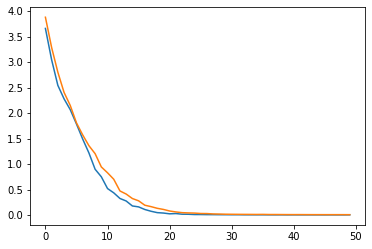

In [24]:
import matplotlib.pyplot as plt

plt.plot(losses_roberta)
plt.plot(losses_bert)
plt.show()